In [125]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

In [60]:
from main import *
from multiprocessing import Pool
import pandas as pd

In [61]:
### common parameters
agnetsCount = 1000
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.005), np.arange(0.1, 1, 0.05)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1, 0.05), np.arange(1, 2.1, 0.5)
])

class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
speedV = 0.03
idx = 1

targetPath = "lastState.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

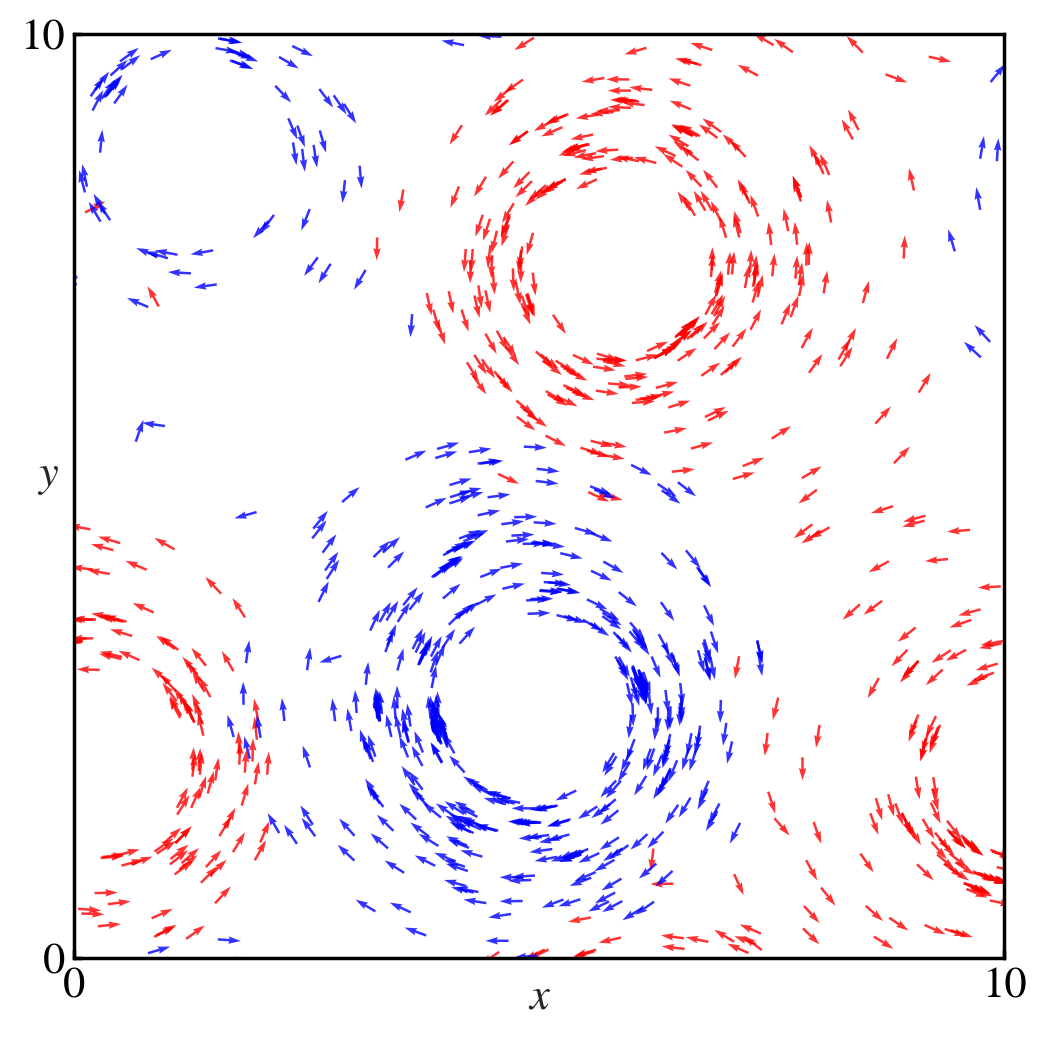

In [142]:
# plot single graphy

def plor_last_state(key: str, ax: plt.Axes = None, 
                    showTicks: bool = False, tickSize: int = 16):
    if ax is None:

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]

    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if showTicks:
        ax.set_xticks([0, 10])
        ax.set_yticks([0, 10])
        ax.set_xlabel(r"$x$", fontsize=tickSize)
        ax.set_ylabel(r"$y$", fontsize=tickSize, rotation=0)
        ax.set_xticklabels(ax.get_xticks(), fontsize=tickSize)
        ax.set_yticklabels(ax.get_yticks(), fontsize=tickSize)
        # 拉近label与坐标轴的距离
        ax.xaxis.labelpad = -10
        ax.yaxis.labelpad = -10
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # ax.text(0.3, 9.2, "A", fontsize=20)
    # ax.text(9.2, 9.2, "B", fontsize=20)
    # ax.text(9.2, 0.3, "C", fontsize=20)
    # ax.text(0.3, 0.3, "D", fontsize=20)
    plt.tick_params(direction='in', length=3)
    

l, d0 = 0.08, 0.15
key = f"{l:.3f}_{d0:.2f}"
plor_last_state(key, showTicks=True)

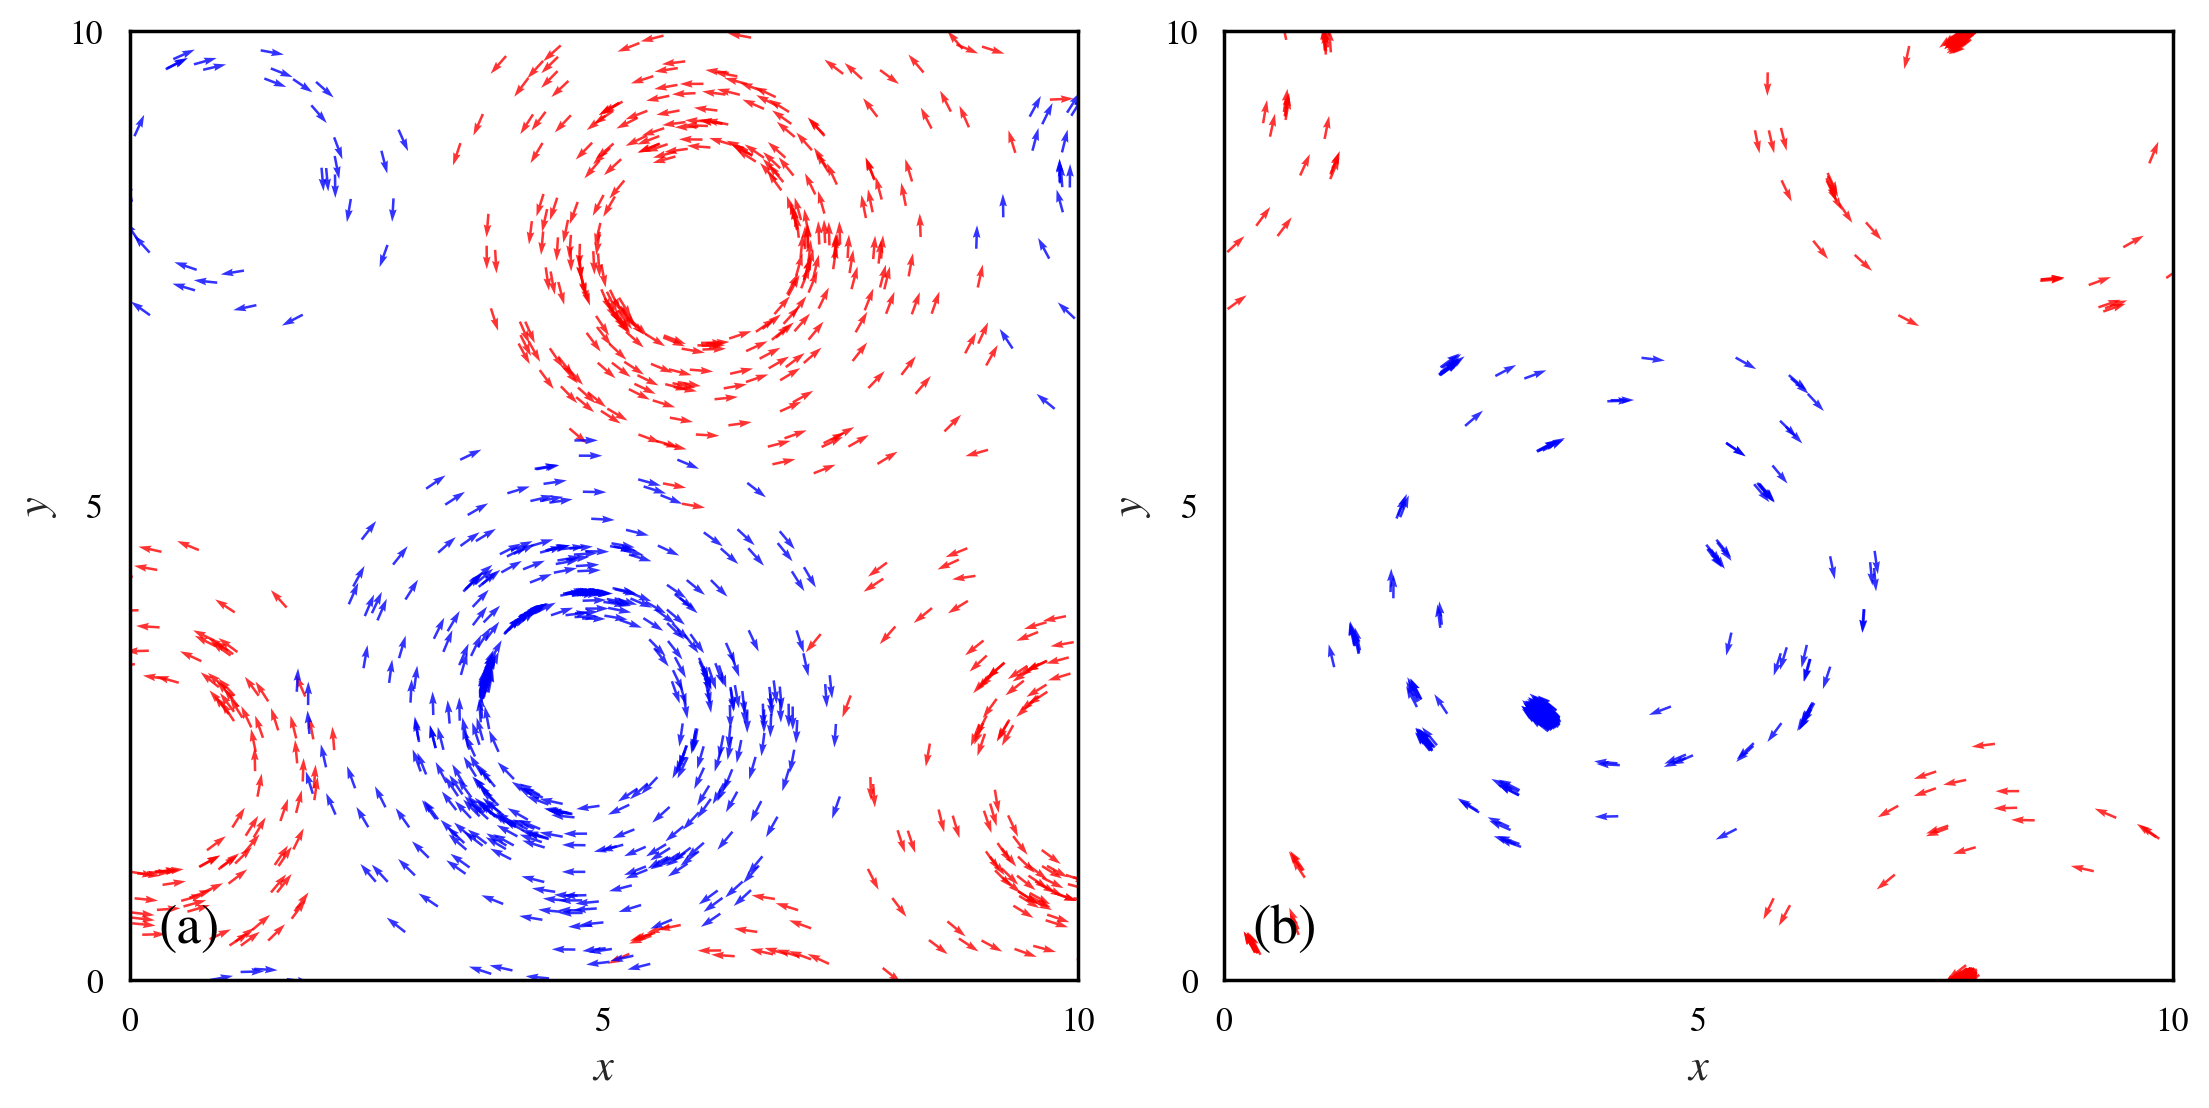

In [12]:
# plot single graphy
l, d0 = 0.015, 0.4

fig, ax = plt.subplots(1, 2, figsize=(11, 5.5))

i = 0
for l, d0 in [
    [0.015, 0.4], [0.5, 0.1]
]:

    singlePositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    singlePhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]

    ax[i].quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax[i].quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )

    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 10)
    ax[i].set_xticks([0, 5, 10])
    ax[i].set_yticks([0, 5, 10])
    ax[i].grid(False)
    ax[i].spines['bottom'].set_color('black')
    ax[i].spines['top'].set_color('black')
    ax[i].spines['left'].set_color('black')
    ax[i].spines['right'].set_color('black')
    if i == 0:
        ax[i].text(0.3, 0.4, r"(a)", fontsize=20)
    else:
        ax[i].text(0.3, 0.4, r"(b)", fontsize=20)
    
    ax[i].set_xlabel(r"$x$", fontsize=16)
    ax[i].set_ylabel(r"$y$", fontsize=16)

    i += 1

plt.tight_layout(
    pad=0.4, w_pad=0.5, h_pad=1.0
)

In [ ]:
@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - (1 - (phaseTheta - 1) / 2) * 256).astype(np.int32)

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

idx = 1

fig = plt.figure(figsize=(len(rangeLambdas) * 4.5, len(distanceDs) * 5))

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SingleDistribution(strengthLambda=l, distanceD0=d0, boundaryLength=5, tqdm=False, savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    
    key = f"{l:.3f}_{d0:.2f}"
    # for i in range(1, 6):
    # try:
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    # except:
    #     continue

    omegaTheta = model.omegaTheta
    plt.quiver(
        lastPositionX[:, 0], lastPositionX[:, 1],
        np.cos(lastPhaseTheta[:]), np.sin(lastPhaseTheta[:]), 
        color=[new_cmap(i) for i in colors_idx(omegaTheta)], alpha=0.8
    )
    plt.scatter(lastPositionX[:, 0], lastPositionX[:, 1],
                c=omegaTheta, cmap=new_cmap, alpha=0.8, vmin=1, vmax=3, s=0.01)
    # print(min(phaseTheta + np.pi), max(phaseTheta + np.pi))
    cbar = plt.colorbar(ticks=[1, 2, 3])
    cbar.ax.set_ylim(1, 3)
    cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
    # ax.quiver(
    #     positionX[class2, 0], positionX[class2, 1],
    #     np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    # )
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)    
    ax.set_title(f"{l:.3f}_{d0:.2f}")
    
    idx += 1

plt.savefig("SingleDistributionBigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

### Plot Big Graph

In [ ]:
fig = plt.figure(figsize=(len(distanceDs) * 5, len(rangeLambdas) * 5))

idx = 1

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    key = f"{l:.3f}_{d0:.2f}"

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]
    singlePointTheta = pointTheta[key]

    # centers = StateAnalysis._calc_centers(singlePositionX, singlePhaseTheta, singlePointTheta, speedV)

    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )
    # ax.scatter(centers[class1, 0], centers[class1, 1], color="orange", s=5)
    # ax.scatter(centers[class2, 0], centers[class2, 1], color="blue", s=5)
    # ax.scatter(centers[:, 0], centers[:, 1], color="green", s=3, alpha=0.7)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    ax.set_title(key)

    idx += 1

plt.tight_layout()
plt.savefig("bigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

# 旋转半径

4.982621803415039
5.0134962448963
5.0283626043579925
4.9320342663212875
4.792685087950748
4.774855126469589


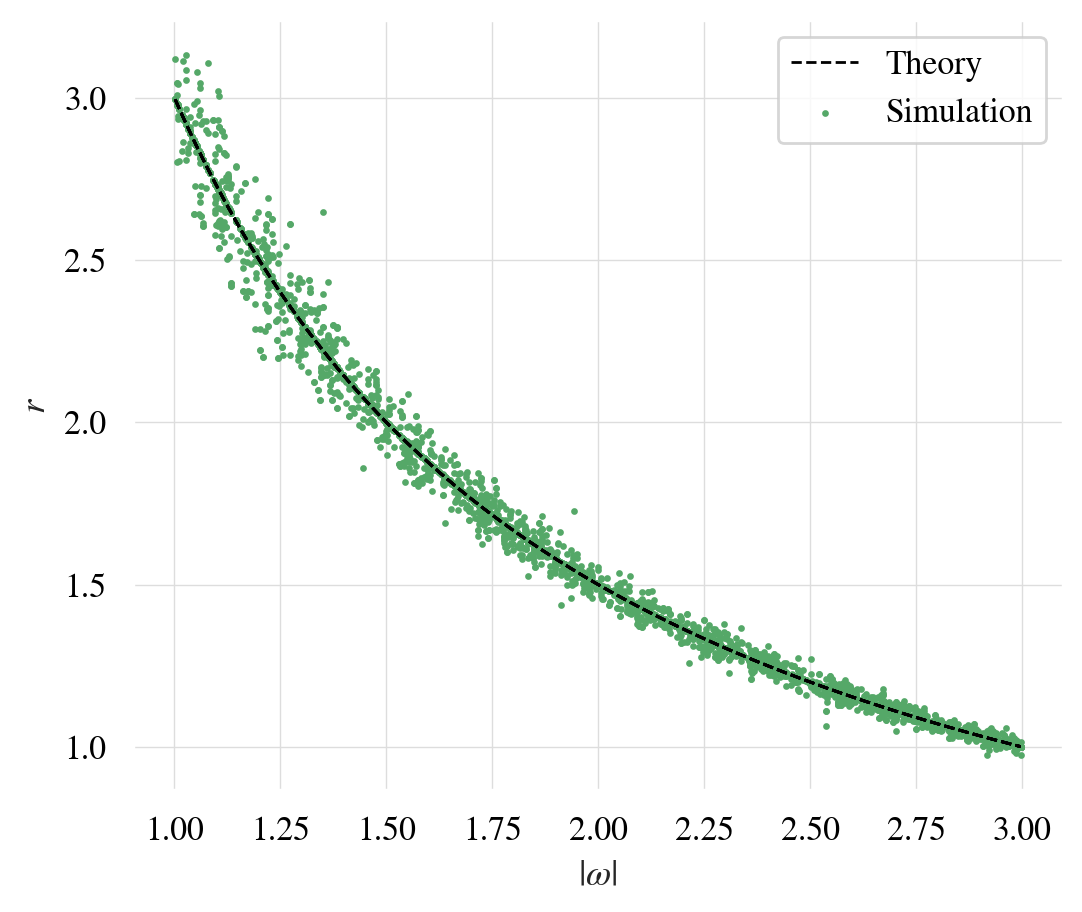

In [21]:
rangeLambdas = np.concatenate([
    np.arange(0.04, 0.1, 0.01)
])
distanceDs = [0.1]
legend = True

for rangeLambda in rangeLambdas:
    
    model = SpatialGroups(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]
    print(lastPositionX.mean())

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    plt.scatter(omegaTheta, distances, s=2, color="C2")
    plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1)
    plt.xlabel(r"$\left| \omega \right|$")
    plt.ylabel(r"$r$")
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Theory")
        plt.scatter(omegaTheta, distances, label="Simulation", s=2, color="C2")
        plt.legend()
# plt.legend(["Theory", "Simulation"])

In [5]:
model = SingleDistribution(
    strengthLambda=0, distanceD0=0, boundaryLength=5, 
    tqdm=True, savePath="./data", distributType="uniform", randomSeed=10, overWrite=False
)
# model.run(500)

Text(0, 0.5, '$r$')

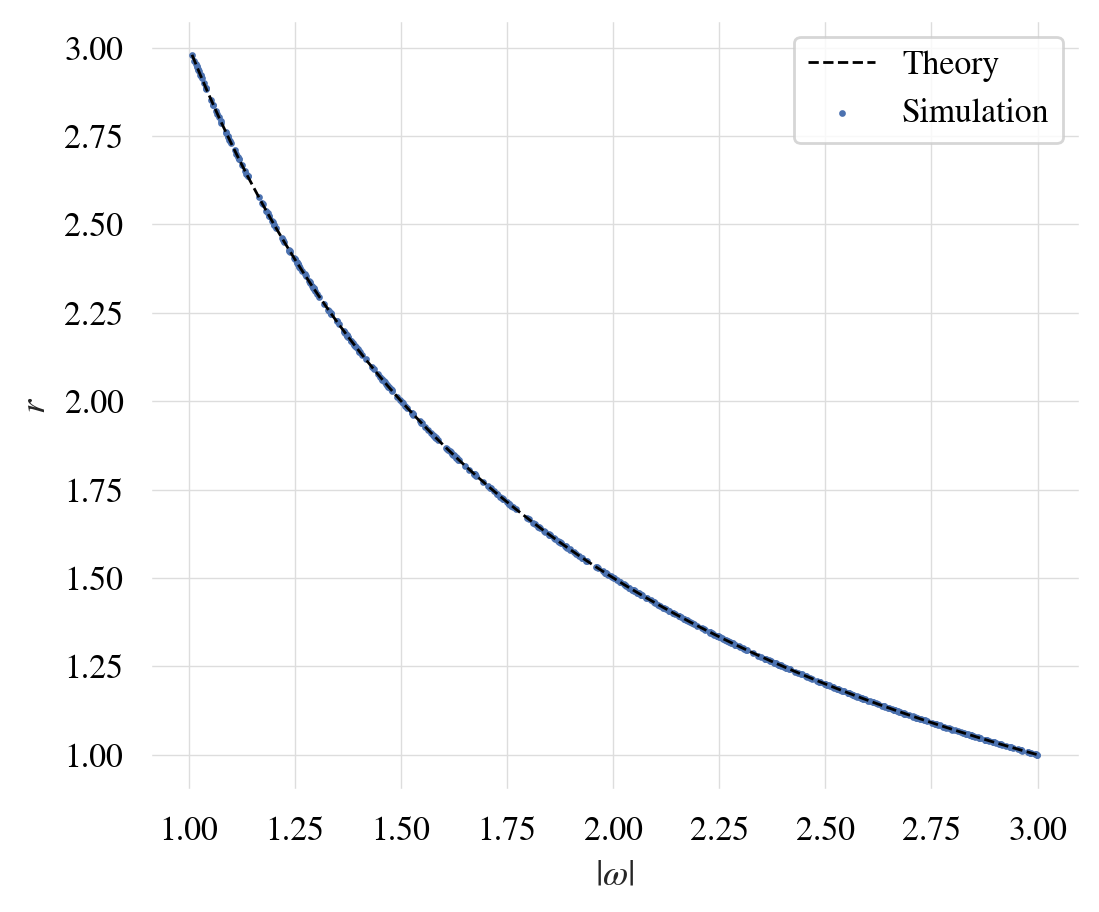

In [8]:
sa = StateAnalysis(model, lookIndex=-1, tqdm=False)
centers = sa.centersNoMod
positionX, phaseTheta, pointTheta = sa.get_state(-1)
distances = np.sqrt(np.sum((centers - positionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
omegaTheta = model.omegaTheta
sort = np.argsort(omegaTheta)
omegaTheta, distances = omegaTheta[sort], distances[sort]

plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Theory")
plt.scatter(omegaTheta, distances, label="Simulation", s=2)
plt.legend()
plt.xlabel(r"$\left| \omega \right|$")
plt.ylabel(r"$r$")

# 序参量

## 截面序参量

### 旋转中心邻域内的其余中心数

In [ ]:
@nb.njit
def _delta_x(positionX, others):
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

# @nb.njit
def nearby_nums(centers: np.ndarray):
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    dist = np.sqrt(np.sum(deltaX ** 2, axis=2))
    return np.sum(dist < 1, axis=1)

maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):
    
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)

    maps.loc[l, d0] = np.mean(nearby_nums(centers)) / 500
    
maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
cbar = plt.colorbar(ticks=[0.06, 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1'])
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=2)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs][::-1])
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

Text(40.234375, 0.5, '$\\lambda$')

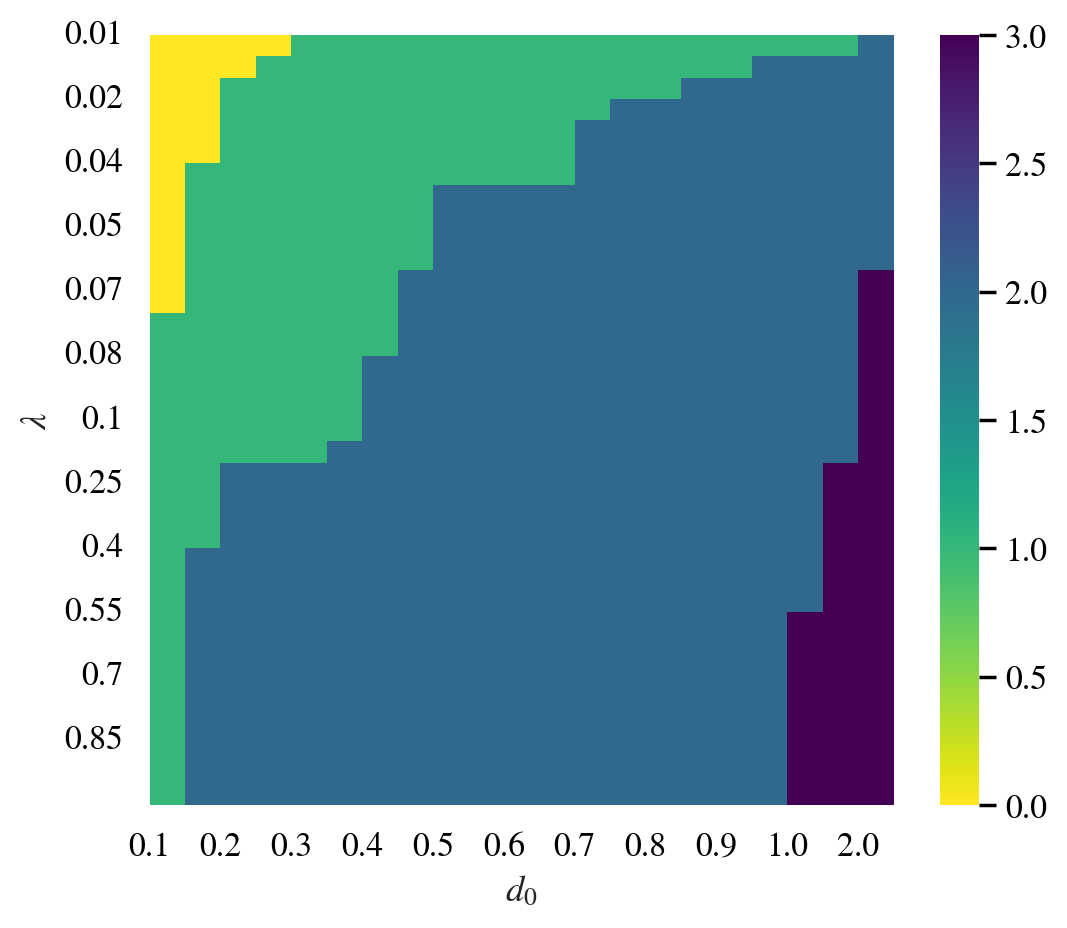

In [25]:
maps = pd.read_excel("maps.xlsx", index_col=0)
sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs], rotation=0)
yIdxs = np.arange(len(rangeLambdas), step=3)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

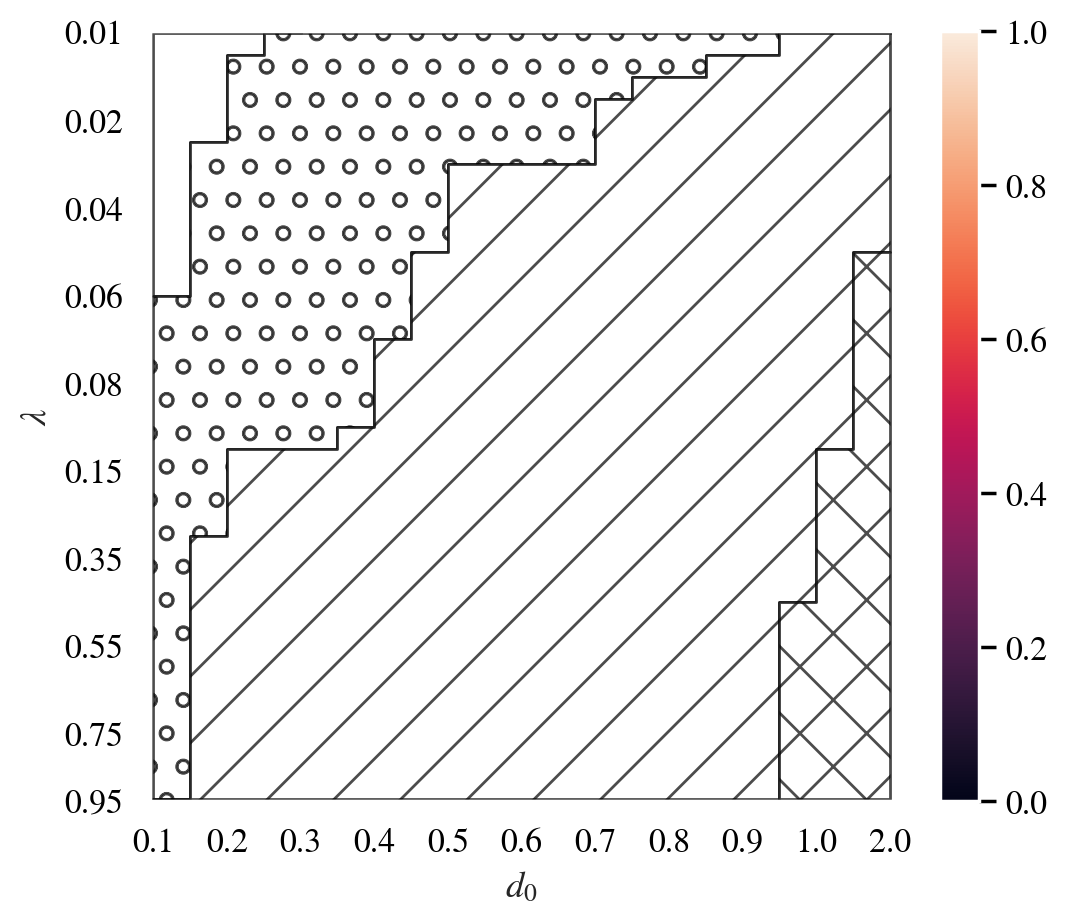

In [238]:
plt.figure(figsize=(6, 5))

hatches = ["", "o", "/", "x"]
stdMaps = maps.copy()
stdMaps.index = np.arange(len(stdMaps), 0, -1)
stdMaps.columns = np.arange(len(stdMaps.columns))

for value in [0, 1, 2, 3]:
    if value == 0:
        upper = []
    elif value == 3:
        upper = lower[-6:]
    else:
        upper = lower
    lower = []
    d0s = []
    for d0 in stdMaps.columns:
        if value not in stdMaps[d0][stdMaps[d0] == value].values:
            continue
        lower.extend([stdMaps[d0][stdMaps[d0] == value].index[-1]] * 2)
        if len(upper) < len(lower):
            upper.extend([stdMaps[d0][stdMaps[d0] == value].index[0]] * 2)
        d0s.extend([d0, d0 + 1])
    if value in [2, 3]:
        d0s = np.array(d0s) - 1
    plt.fill_between(
        d0s, lower, upper, alpha=0.7, hatch=hatches[value], color="white", edgecolor='black', # linewidth=1.5
    )

# plt.legend(bbox_to_anchor=(1.02, 1))
plt.scatter(0, 0, color="k", label="0")
plt.colorbar()
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=4).tolist()
ylabels = np.round(rangeLambdas, 2)[::-1][yIdxs].tolist()
yIdxs.extend([stdMaps.index.min() - 0.1, stdMaps.index.max() + 0.1])
ylabels.extend([np.round(max(rangeLambdas), 2), min(rangeLambdas)])
plt.yticks(yIdxs, ylabels)
plt.xlim(stdMaps.columns.min() - 0.1, stdMaps.columns.max() + 0.1)
plt.ylim(stdMaps.index.min() - 0.1, stdMaps.index.max() + 0.1)
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")
plt.grid(False)
plt.show()

### 相位(速度方向)同步率

Text(0, 0.5, '$\\lambda$')

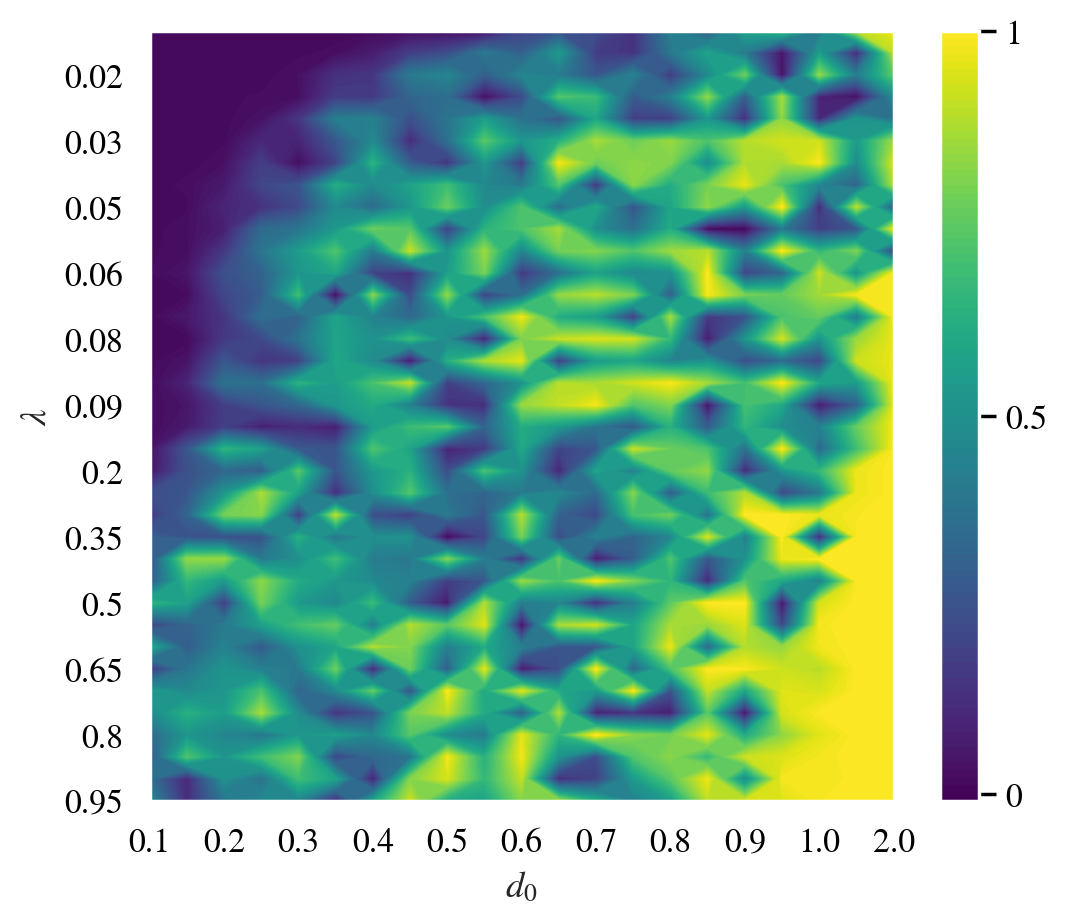

In [181]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    phaseAggOp = StateAnalysis._clac_phase_sync_op(lastPhaseTheta)
    maps.loc[l, d0] = phaseAggOp

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
cbar = plt.colorbar(ticks=[np.min(maps.values), 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1'])
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=3)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[::-1][yIdxs])
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

In [ ]:
### 旋转中心空间聚集程度1
# maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

# for l, d0 in product(rangeLambdas, distanceDs):

#     lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
#     lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
#     lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

#     centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
#     centers = np.mod(centers, 10)
#     deltaX = _delta_x(centers, centers[:, np.newaxis])
#     centerAggOp = np.sqrt(np.sum(deltaX ** 2, axis=2)).mean(axis=1)
    
#     maps.loc[l, d0] = np.mean(centerAggOp)

# maps.index = np.round(maps.index, 4)
# maps.columns = np.round(maps.columns, 4)
# sns.heatmap(maps, cmap="viridis_r")
# plt.xlabel(r"$d_0$")
# plt.ylabel(r"$\lambda$")

### 旋转中心空间聚集程度2
# maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

# for l, d0 in product(rangeLambdas, distanceDs):

#     lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
#     lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
#     lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

#     centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
#     centers = np.mod(centers, 10)
#     deltaX = _delta_x(centers, centers[:, np.newaxis])
#     centerAggOp = np.sqrt(np.sum(deltaX.mean(axis=1) ** 2, axis=-1))
    
#     maps.loc[l, d0] = np.mean(centerAggOp)

# maps.index = np.round(maps.index, 4)
# maps.columns = np.round(maps.columns, 4)
# sns.heatmap(maps, cmap="viridis")
# plt.xlabel(r"$d_0$")
# plt.ylabel(r"$\lambda$")

In [ ]:
### 粒子空间聚集程度2
# maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

# for l, d0 in product(rangeLambdas, distanceDs):

#     lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
#     lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
#     lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

#     deltaX = _delta_x(lastPositionX, lastPositionX[:, np.newaxis])
#     centerAggOp = np.sqrt(np.sum(deltaX.mean(axis=1) ** 2, axis=-1))
    
#     maps.loc[l, d0] = np.mean(centerAggOp)

# maps.index = np.round(maps.index, 4)
# maps.columns = np.round(maps.columns, 4)
# sns.heatmap(maps, cmap="viridis")
# plt.xlabel(r"$d_0$")
# plt.ylabel(r"$\lambda$")

### 粒子空间距离标准差
# maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

# for l, d0 in product(rangeLambdas, distanceDs):

#     lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
#     lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
#     lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

#     deltaX = _delta_x(lastPositionX, lastPositionX[:, np.newaxis])
#     centerAggOp = np.sqrt(np.sum(deltaX ** 2, axis=-1))
#     # assert 0
#     maps.loc[l, d0] = np.std(centerAggOp)

# maps.index = np.round(maps.index, 4)
# maps.columns = np.round(maps.columns, 4)
# sns.heatmap(maps, cmap="viridis")
# plt.xlabel(r"$d_0$")
# plt.ylabel(r"$\lambda$")

### 聚类平均相位同步程度

Text(0, 0.5, '$\\lambda$')

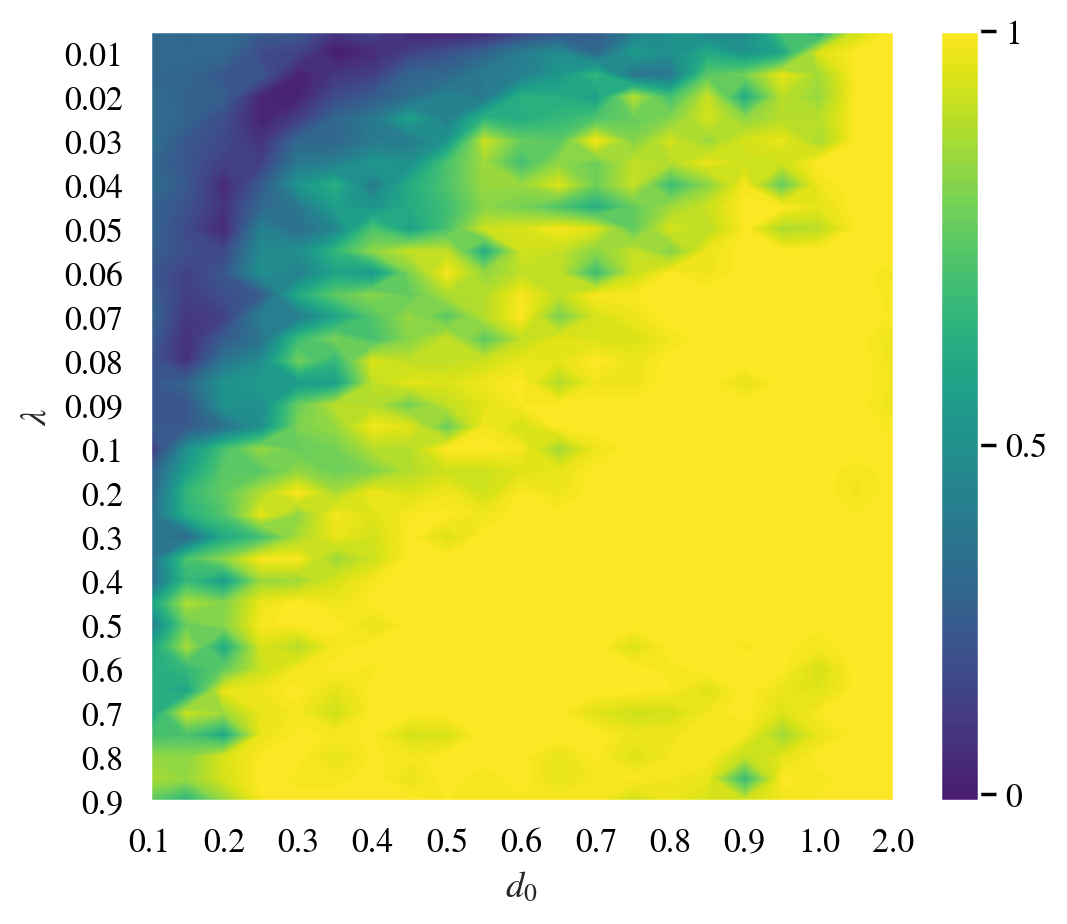

In [14]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0
    for classOcsis in classes:
        if len(classOcsis) < 5:
            continue
        sumR += StateAnalysis._clac_phase_sync_op(lastPhaseTheta[classOcsis])
        counts += 1
    
    maps.loc[l, d0] = sumR / counts

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
cbar = plt.colorbar(ticks=[np.min(maps.values), 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1'])
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=2)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs][::-1])
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

In [4]:
def lambda_c1(d0):
    r1 = 1
    r2 = 1
    deltaOmega = 2
    N = 500
    phi = 2 * np.pi / N
    u = 0.05
    d = np.sqrt(r1**2 + r2**2 - 2 * r1 * r2 * np.cos(phi))
    f = np.exp((d - d0) / u)
    return deltaOmega * f / 2

def lambda_c2(d0):
    rs = 1
    deltaOmega = 2
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    N = 500
    return (
        np.pi * rs ** 2 * deltaOmega
        / (N - 1)
        / (alpha * d0**2 / 2 + beta * rs**2 / 2 - rs * d0 * np.sin(alpha / 2))
    )

def lambda_c3(d0):
    L = 10
    deltaOmega = 2
    N = 1000
    return (
        deltaOmega
        / (N * np.pi * d0 ** 2 / L ** 2)
    )

def lambda_c4(d0):
    L = 10
    rc = 1.5
    rs = 1.5
    if d0 + 2 * (rc + rs) < L / np.sqrt(2):
        # print(d0 + 2 * (rc + rs), L / np.sqrt(2))
        return np.inf
    deltaOmega = 6
    N = 500
    rh = L / np.sqrt(2) - 2 * (rc + rs)
    rd = rh + rs
    beta = 2 * np.arccos((d0 ** 2 + rd ** 2 - rs ** 2) / (2 * d0 * rd))
    alpha = 2 * np.arccos((rd ** 2 + rs ** 2 - d0 ** 2) / (2 * rd * rs))
    si = alpha * rs ** 2 / 2 + beta * d0 ** 2 / 2 - d0 * rd * np.sin(beta / 2)
    Ni = N * si / (np.pi * rs ** 2)
    return deltaOmega / Ni

In [ ]:
lambdas = dict()
for func in [lambda_c1, lambda_c2, lambda_c3, lambda_c4]:
    lambdas[func] = []
    for d0 in distanceDs:
        lambdas[func].append(func(d0) * -1)

plt.figure(figsize=(6, 5))
for func, values in lambdas.items():
    plt.plot(distanceDs, values, label=func.__name__)
plt.ylim(-1, 0)

In [15]:
funcIdxs = dict()
for func in [lambda_c1, lambda_c2, lambda_c3, lambda_c4]:
    funcIdxs[func] = []
    for d0 in maps.columns:
        l = func(d0)
        idx = 0
        upper = maps.index[maps.index > l].min()
        if np.isnan(upper):
            upper = maps.index.max()
        idx = idx + np.where(maps.index == upper)[0][0]
        lower = maps.index[maps.index < l].max()
        if np.isnan(lower):
            lower = maps.index.min()
        idx = idx + np.where(maps.index == lower)[0][0]
        funcIdxs[func].append(idx / 2)

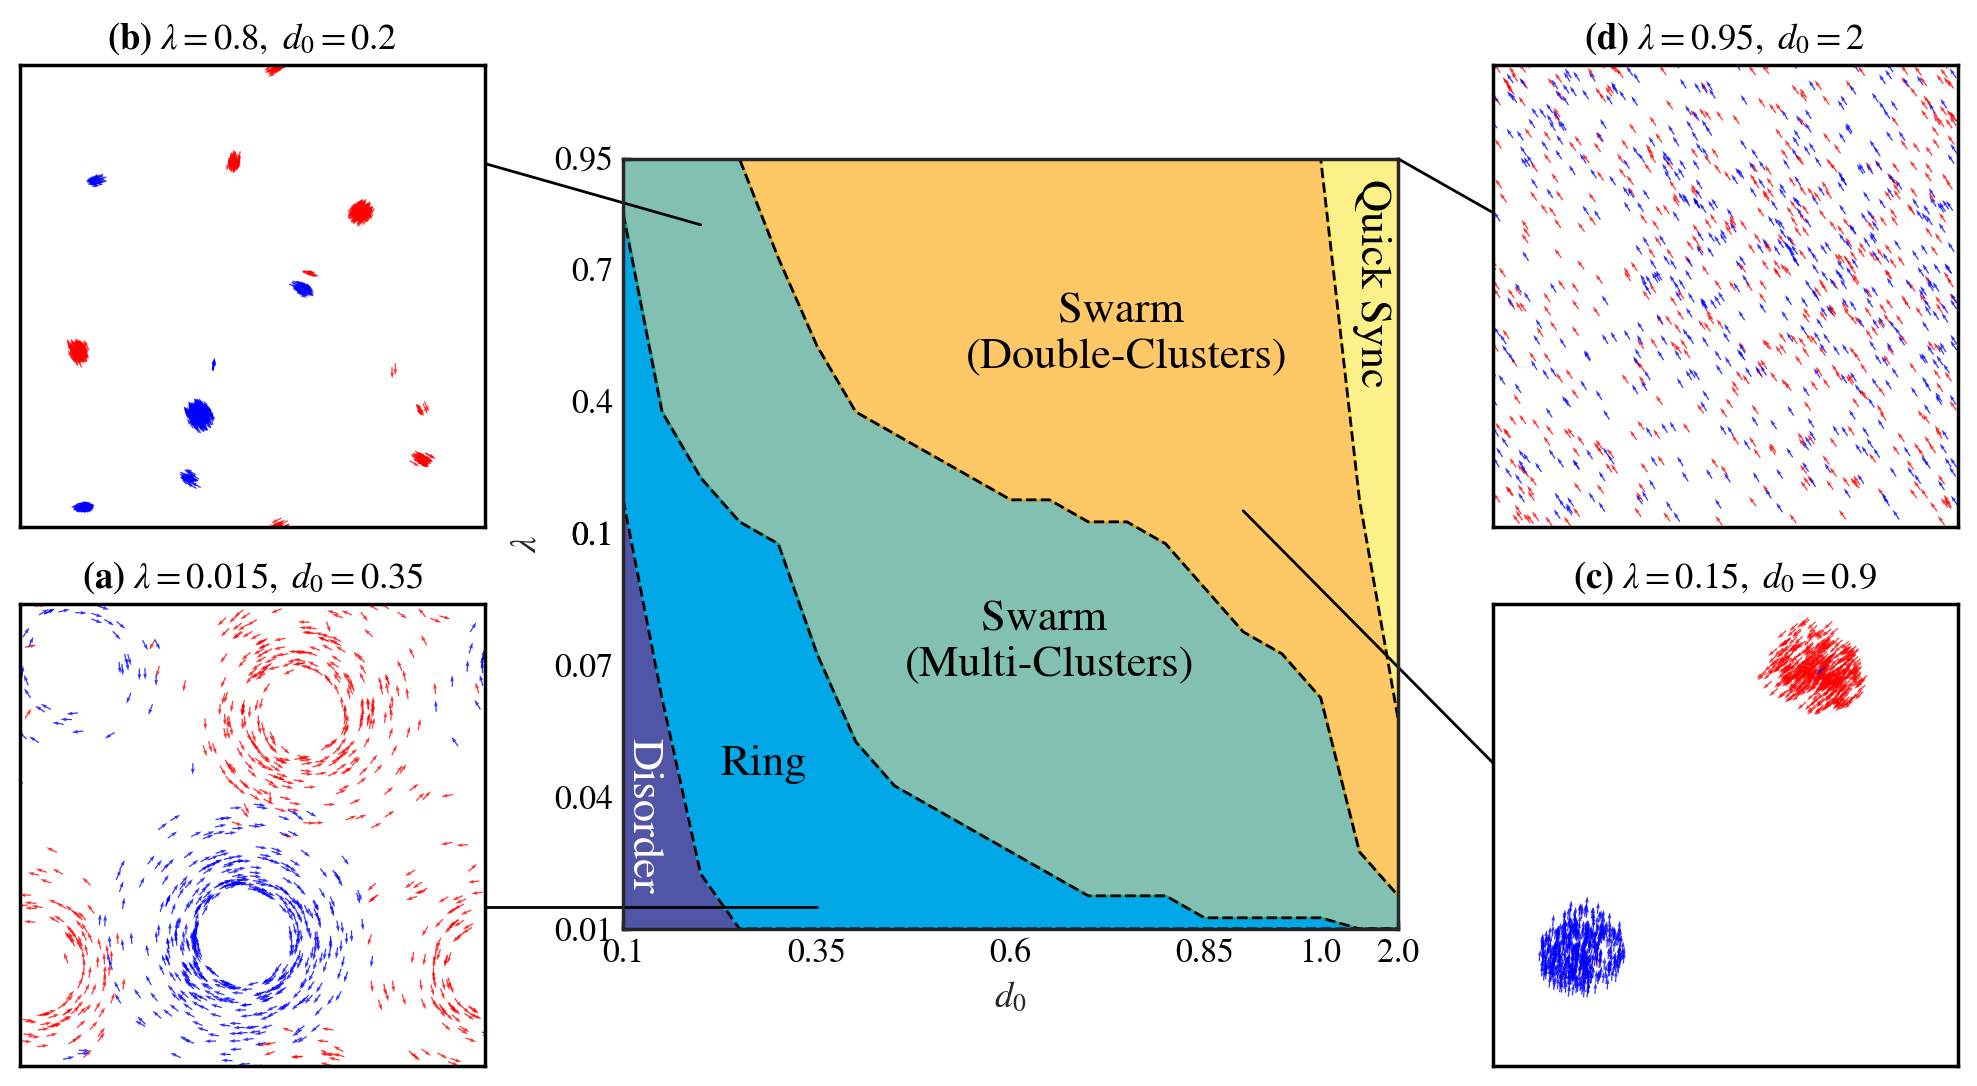

In [368]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c1],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), 0, funcIdxs[lambda_c1], alpha=1, color="#5055A6"
)
plt.text(0, 2, "Disorder", fontsize=16, color="white", rotation=-90)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c1], funcIdxs[lambda_c2], alpha=1, color="#00A8E7"
)
plt.text(2.5, 7, "Ring", fontsize=16, color="black")
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c2], funcIdxs[lambda_c3], alpha=0.6, color="#2F997D"
)
plt.text(11, 13, "Swarm \n(Multi-Clusters)", ha="center", va="center", fontsize=16, color="black")
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c3], funcIdxs[lambda_c4], alpha=0.6, color="#FFA400"
)
plt.text(13, 27, "Swarm \n(Double-Clusters)", ha="center", va="center", fontsize=16, color="black")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c4], 35, alpha=0.6, color="#FBE63B"
)
plt.text(18.8, 25, "Quick Sync", fontsize=16, color="Black", rotation=-90)
xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6), [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.tick_params(direction='in', length=3)

plt.xlim(0, 20)
plt.ylim(0, 35)
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")
plt.grid(False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axRing = inset_axes(ax, width="40%", height="40%", loc='lower left',
                    bbox_to_anchor=(-0.8, -0.2, 1.5, 1.5),
                    bbox_transform=ax.transAxes)
ax.plot([-4, 5], [1, 1], clip_on=False, color="black", lw=1)
plor_last_state(f"{0.015:.3f}_{0.35:.2f}", ax=axRing)
axRing.set_title(r"$\mathbf{(a)}\ \lambda=0.015,\ d_0=0.35$")

axSwarmM = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(-0.8, 0.5, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
ax.plot([-4, 2], [35, 32], clip_on=False, color="black", lw=1)
plor_last_state(f"{0.8:.3f}_{0.2:.2f}", ax=axSwarmM)
axSwarmM.set_title(r"$\mathbf{(b)}\ \lambda=0.8,\ d_0=0.2$")

axSwarmD = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(1.1, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
ax.plot([25, 16], [3, 19], clip_on=False, color="black", lw=1)
plor_last_state(f"{0.15:.3f}_{0.9:.2f}", ax=axSwarmD)
axSwarmD.set_title(r"$\mathbf{(c)}\ \lambda=0.15,\ d_0=0.9$")

axQuickSync = inset_axes(ax, width="40%", height="40%", loc='lower left',
                         bbox_to_anchor=(1.1, 0.5, 1.5, 1.5),
                         bbox_transform=ax.transAxes)
ax.plot([25, 20], [30, 35], clip_on=False, color="black", lw=1)
plor_last_state(f"{0.95:.3f}_{2:.2f}", ax=axQuickSync)
axQuickSync.set_title(r"$\mathbf{(d)}\ \lambda=0.95,\ d_0=2$")

# 保存为矢量图
plt.savefig("./PJT_C_Fig/phaseDiagram.pdf", bbox_inches="tight")

In [344]:
distanceDs[16], rangeLambdas[19]

(0.9000000000000002, 0.15000000000000002)

In [264]:
distanceDs[8]

0.5000000000000001

In [201]:
inset_axes?

Signature:
inset_axes(
    parent_axes,
    width,
    height,
    loc='upper right',
    bbox_to_anchor=None,
    bbox_transform=None,
    axes_class=None,
    axes_kwargs=None,
    borderpad=0.5,
)
Docstring:
Create an inset axes with a given width and height.

Both sizes used can be specified either in inches or percentage.
For example,::

    inset_axes(parent_axes, width='40%', height='30%', loc='lower left')

creates in inset axes in the lower left corner of *parent_axes* which spans
over 30% in height and 40% in width of the *parent_axes*. Since the usage
of `.inset_axes` may become slightly tricky when exceeding such standard
cases, it is recommended to read :doc:`the examples
</gallery/axes_grid1/inset_locator_demo>`.

Notes
-----
The meaning of *bbox_to_anchor* and *bbox_to_transform* is interpreted
differently from that of legend. The value of bbox_to_anchor
(or the return value of its get_points method; the default is
*parent_axes.bbox*) is transformed by the bbox_transform

In [107]:
len(np.arange(0.1, 1, 0.05))

18

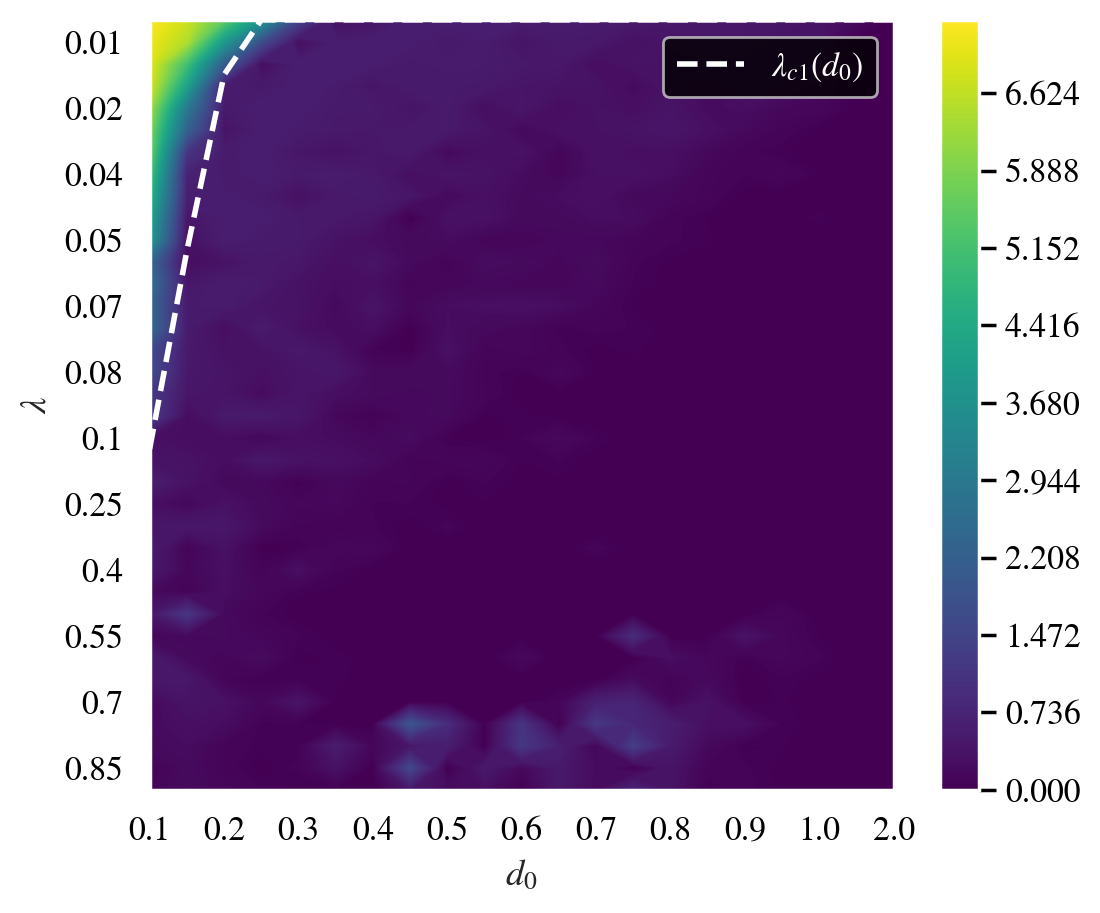

In [179]:
maps = pd.read_csv("clusterDeltaOmega2.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps.index = maps.index.astype(float)
maps.columns = maps.columns.astype(float)
plt.figure(figsize=(6, 5))
plt.contourf(
    # maps.columns.values, 
    # maps.index.values, 
    maps.values[::-1], levels=1000, # vmin=0, vmax=1,
    cmap="viridis", zorder = 1
)
plt.plot(np.arange(maps.shape[1]), maps.shape[0] - np.array(funcIdxs[lambda_c1]) - 1,
         linestyle="--", color="white", lw=2, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
# plt.plot(maps.columns, lambda_c1(maps.columns), linestyle="--", color="black", lw=1, zorder = 2)
# plt.ylim(maps.index.min(), maps.index.max())
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=3)
plt.yticks(yIdxs[::-1] + 1, np.round(rangeLambdas, 2)[yIdxs])
cbar = plt.colorbar()
# cbar = plt.colorbar(ticks=[np.min(maps.values), 0.5, 1])
# cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")
plt.legend(frameon=True, labelcolor="white", facecolor="black")

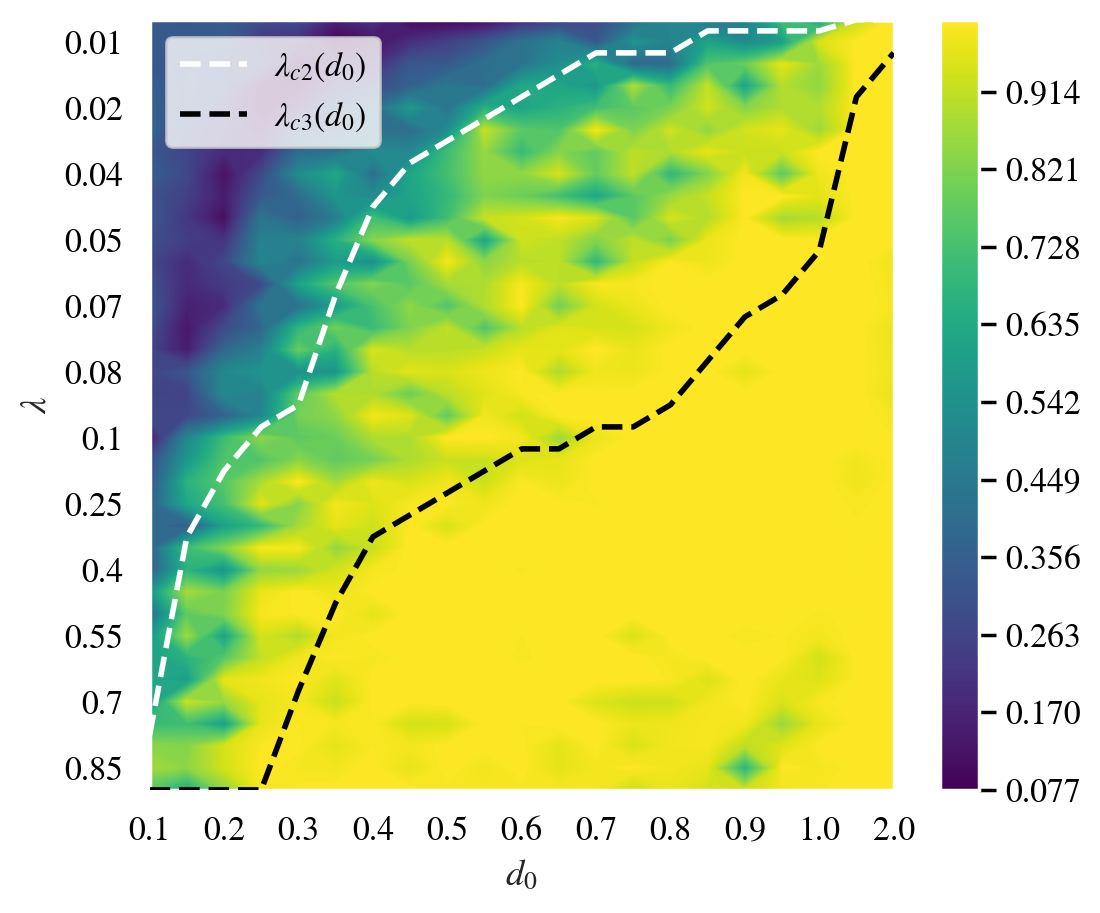

In [178]:
plt.figure(figsize=(6, 5))
plt.contourf(
    # maps.columns.values, 
    # maps.index.values, 
    maps.values[::-1], levels=1000, # vmin=0, vmax=1,
    cmap="viridis", zorder = 1
)
plt.plot(np.arange(maps.shape[1]), maps.shape[0] - np.array(funcIdxs[lambda_c2]) - 1,
         linestyle="--", color="white", lw=2, zorder = 2, label=r"$\lambda_{c2}(d_0)$")
# plt.plot(np.arange(maps.shape[1]), maps.shape[0] - np.array(funcIdxs[lambda_c3]) - 1,
#          linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), maps.shape[0] - np.array(funcIdxs[lambda_c3]) - 1,
         linestyle="--", color="black", lw=2, zorder = 3, label=r"$\lambda_{c3}(d_0)$")
# plt.plot(maps.columns, lambda_c1(maps.columns), linestyle="--", color="black", lw=1, zorder = 2)
# plt.ylim(maps.index.min(), maps.index.max())
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=3)
plt.yticks(yIdxs[::-1] + 1, np.round(rangeLambdas, 2)[yIdxs])
cbar = plt.colorbar()
# cbar = plt.colorbar(ticks=[np.min(maps.values), 0.5, 1])
# cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")
plt.legend(frameon=True, labelcolor="black")

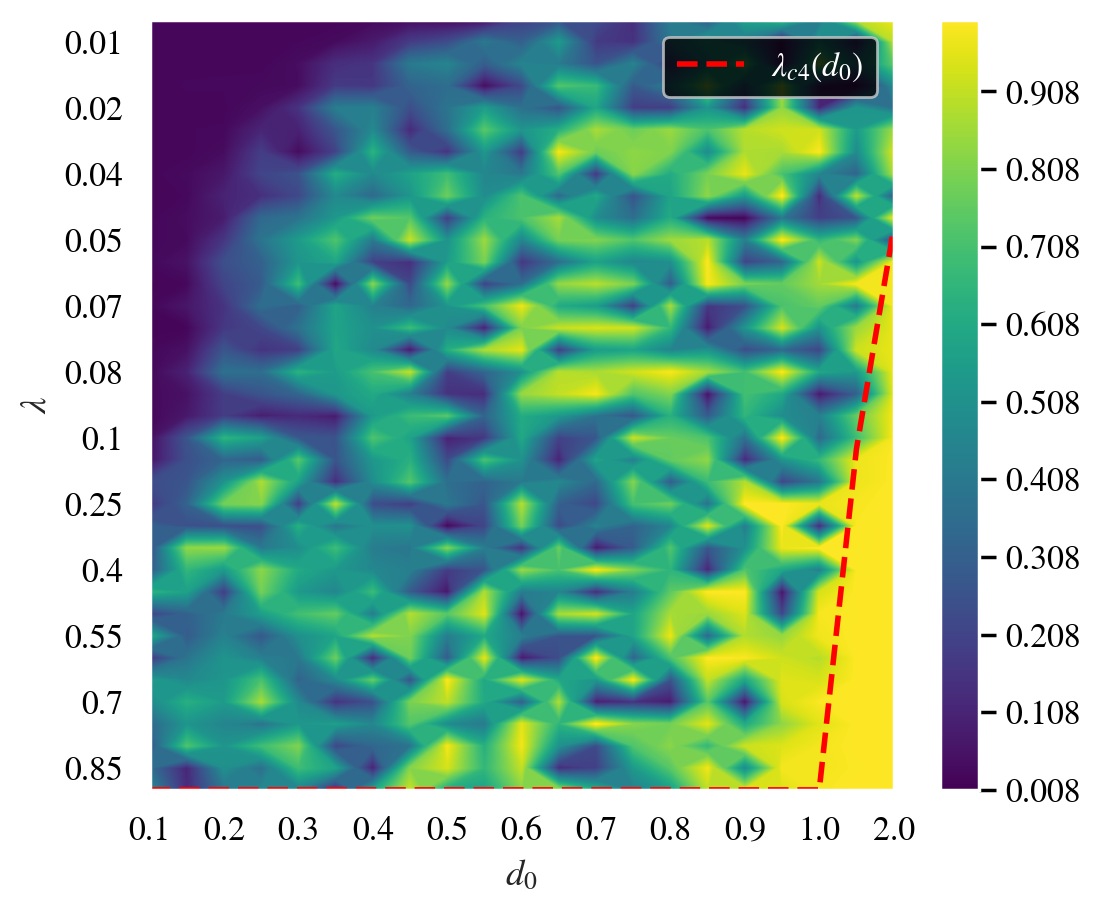

In [182]:
plt.figure(figsize=(6, 5))
plt.contourf(
    # maps.columns.values, 
    # maps.index.values, 
    maps.values[::-1], levels=1000, # vmin=0, vmax=1,
    cmap="viridis", zorder = 1
)
plt.plot(np.arange(maps.shape[1]), maps.shape[0] - np.array(funcIdxs[lambda_c4]) - 1,
         linestyle="--", color="red", lw=2, zorder = 2, label=r"$\lambda_{c4}(d_0)$")
# plt.plot(maps.columns, lambda_c1(maps.columns), linestyle="--", color="black", lw=1, zorder = 2)
# plt.ylim(maps.index.min(), maps.index.max())
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=3)
plt.yticks(yIdxs[::-1] + 1, np.round(rangeLambdas, 2)[yIdxs])
cbar = plt.colorbar()
# cbar = plt.colorbar(ticks=[np.min(maps.values), 0.5, 1])
# cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")
plt.legend(frameon=True, labelcolor="white", facecolor="black")

In [173]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `.Axes.legend` without
any arguments and without setting 

In [52]:
import numpy as np
from sympy import symbols, Matrix

# 定义符号变量
a = symbols('a')
b = symbols('b')
v = symbols('v')
l = symbols('l')

# 创建一个矩阵
A = np.array([[0, 0, -v, 0,    0],
              [0, 0, 0,  v,    0],
              [a, 0, 0,  0,   -l],
              [0, b, 0,  0,    l],
              [0, 0, 0,  0, -2*l]])

# 将NumPy矩阵转换为SymPy矩阵
M = Matrix(A)

# 计算特征值
eigenvalues = M.eigenvals(multiple=False)

# 打印特征值
for eigenvalue, multiplicity in eigenvalues.items():
    print(f"特征值: {eigenvalue}, 多重度: {multiplicity}")

特征值: -2*l, 多重度: 1
特征值: -sqrt(-a*v), 多重度: 1
特征值: sqrt(-a*v), 多重度: 1
特征值: -sqrt(b*v), 多重度: 1
特征值: sqrt(b*v), 多重度: 1


In [26]:
np.arange(len(rangeLambdas), 0, step=-3)

array([36, 33, 30, 27, 24, 21, 18, 15, 12,  9,  6,  3])

### 聚类平均距离方差

Text(40.234375, 0.5, '$\\lambda$')

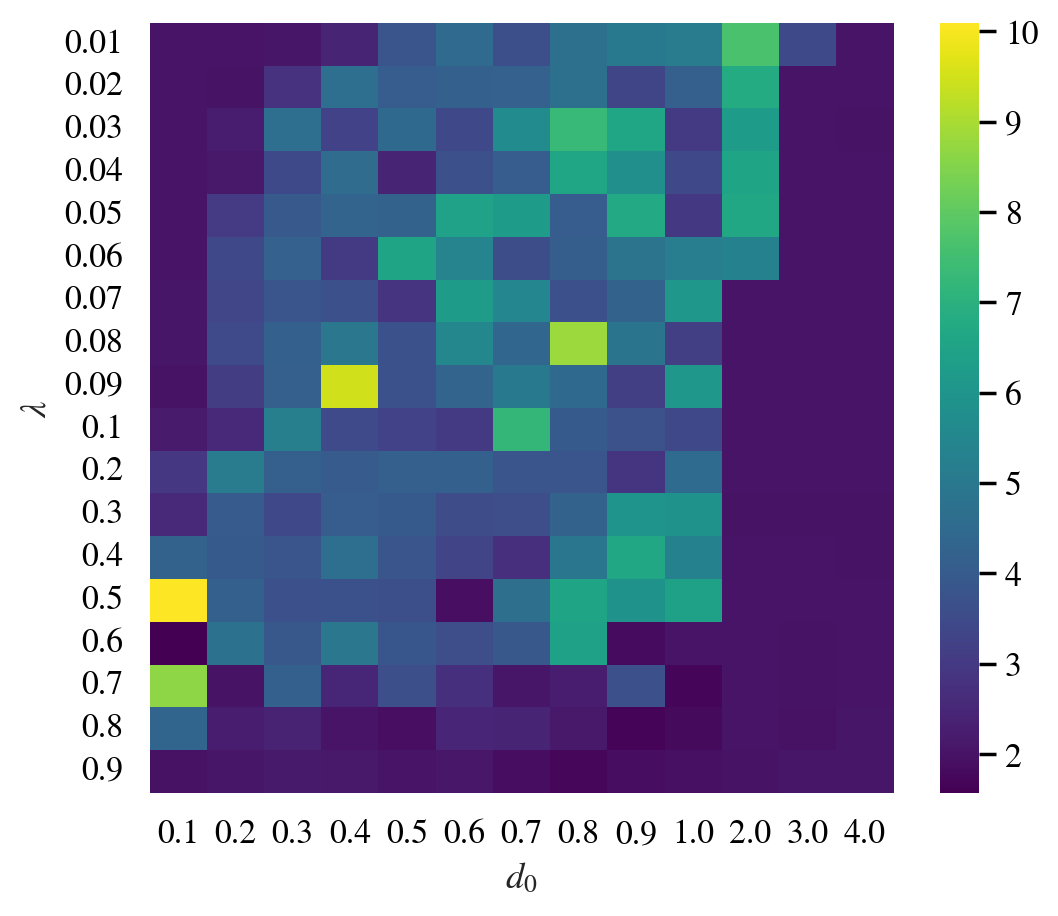

In [41]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    distances = StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    classes = StateAnalysis._calc_classes(centers, 1, distances)
    counts = 0
    sumR = 0
    for classOcsis in classes:
        # if len(classOcsis) < 5:
        #     continue
        classDis = distances[classOcsis]
        sumR += np.var(classDis[classDis != 0])
        counts += 1
    
    maps.loc[l, d0] = sumR / counts

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 聚类数

Text(0, 0.5, '$\\lambda$')

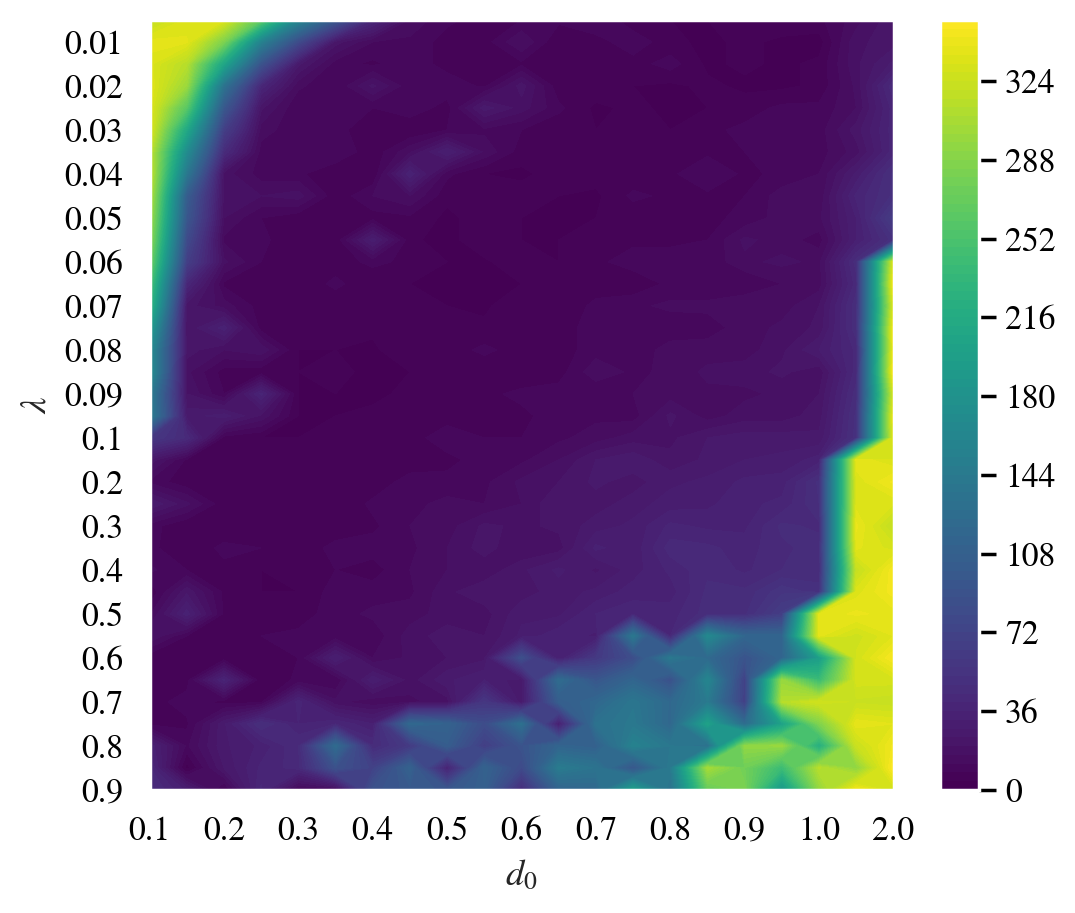

In [86]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    
    maps.loc[l, d0] = len(classes)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
plt.contourf(
    maps[::-1], levels=100, vmin=2,
    cmap="viridis",
)
cbar = plt.colorbar()
# cbar.ax.set_yticklabels(['0', '0.5', '1'])
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=2)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs][::-1])
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 中心距离倒数加权相位同步程度

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == "":


Text(40.234375, 0.5, '$\\lambda$')

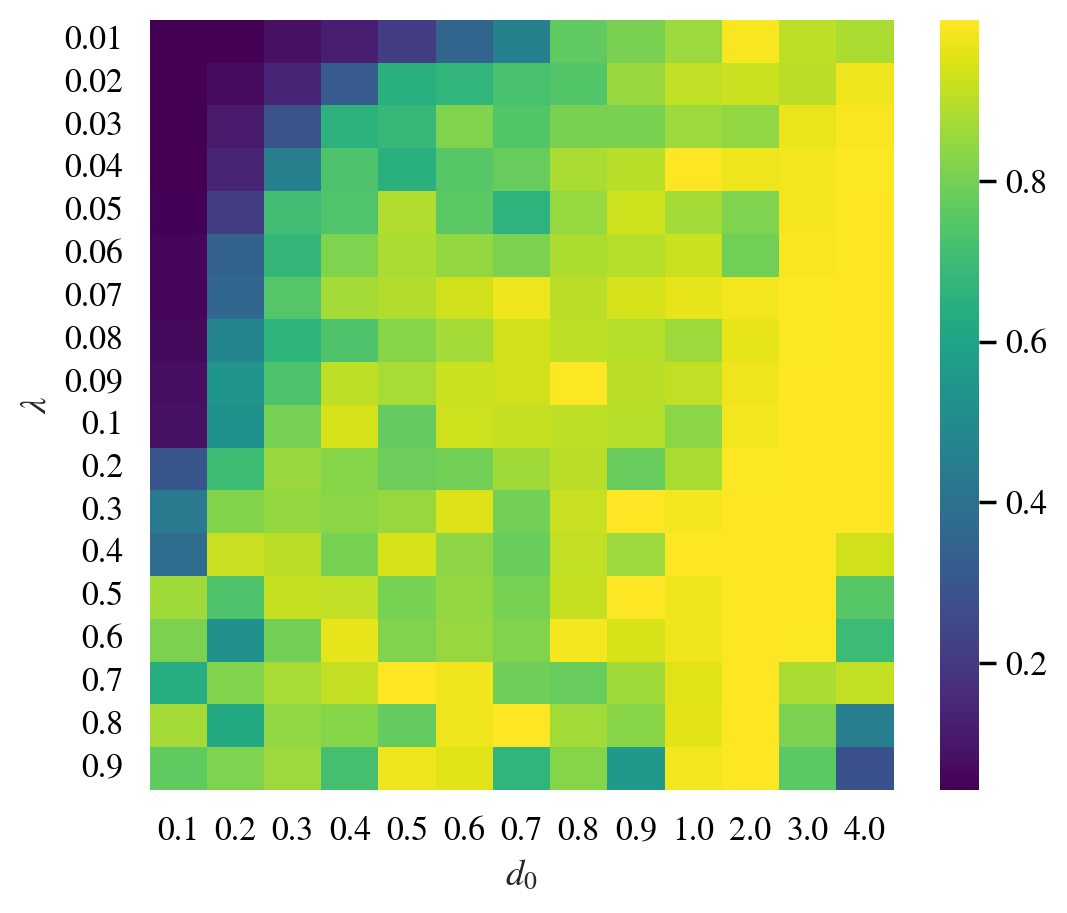

In [7]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    centerDisMat = 1 / np.sqrt(np.sum(deltaX ** 2, axis=-1))
    centerDisMat[np.isinf(centerDisMat)] = 0
    # rowWgtPhase = lastPhaseTheta * centerDisMat / centerDisMat.sum(axis=0)
    N = centers.shape[0]
    phaseSyncs = [
        (
            (np.sum(np.sin(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2 + 
            (np.sum(np.cos(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2
        )**0.5
        for rowIdx in range(N)
    ]
    maps.loc[l, d0] = np.mean(phaseSyncs)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 旋转中心邻域内相位同步程度

Text(0, 0.5, '$\\lambda$')

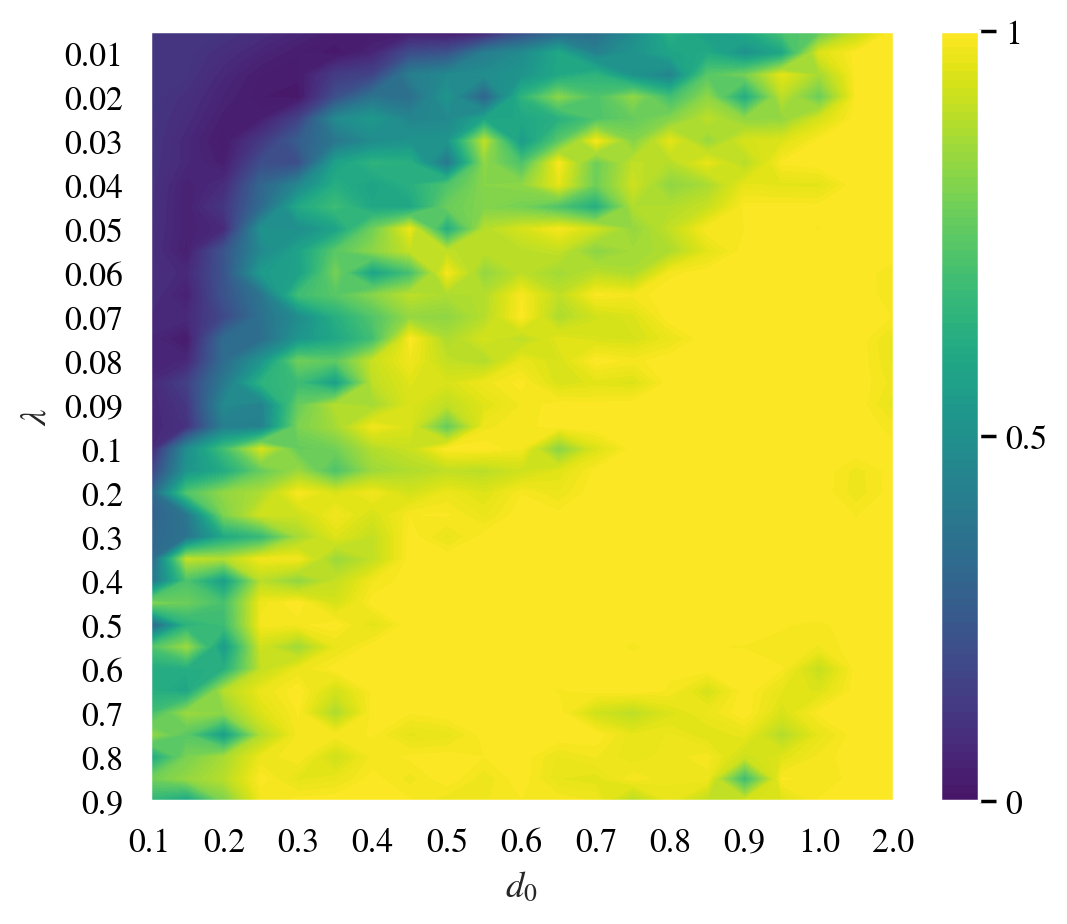

In [37]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    distanceMat = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    centerDisMat = distanceMat < 1
    # rowWgtPhase = lastPhaseTheta * centerDisMat / centerDisMat.sum(axis=0)
    N = centers.shape[0]
    phaseSyncs = [
        (
            (np.sum(np.sin(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2 + 
            (np.sum(np.cos(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2
        )**0.5
        for rowIdx in range(N)
    ]
    maps.loc[l, d0] = np.mean(phaseSyncs)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
cbar = plt.colorbar(ticks=[0.05, 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1'])
xIdxs = np.arange(len(distanceDs), step=2)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.arange(len(rangeLambdas), step=2)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs][::-1])
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

In [32]:
yIdxs

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33])

In [30]:
np.round(rangeLambdas, 2)[yIdxs][::-1]

array([0.85, 0.7 , 0.55, 0.4 , 0.25, 0.1 , 0.08, 0.07, 0.05, 0.04, 0.02,
       0.01])

### 半径与理论半径差异

Text(40.234375, 0.5, '$\\lambda$')

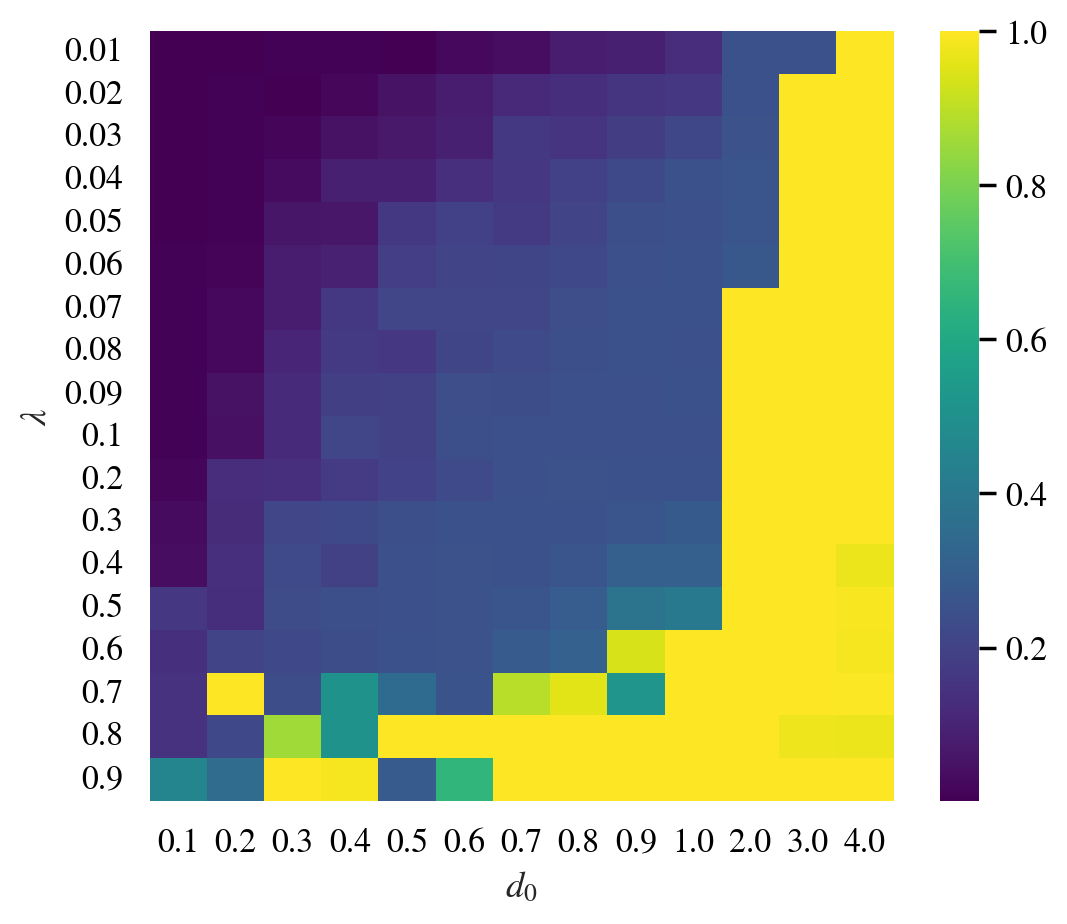

In [30]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    model = SpatialGroups(
        strengthLambda=l, distanceD0=d0, boundaryLength=5, 
        tqdm=False, savePath="./data", randomSeed=10, overWrite=False
    ) 
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centerRadius = np.sqrt(np.sum((lastPositionX - centers) ** 2, axis=-1))
    omegaTheta = np.abs(model.omegaTheta)
    theryRadius = 3 / omegaTheta
    maps.loc[l, d0] = np.mean(np.abs(centerRadius - theryRadius) / theryRadius)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis", vmax=1)
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 粒子耦合半径内粒子数

Text(40.234375, 0.5, '$\\lambda$')

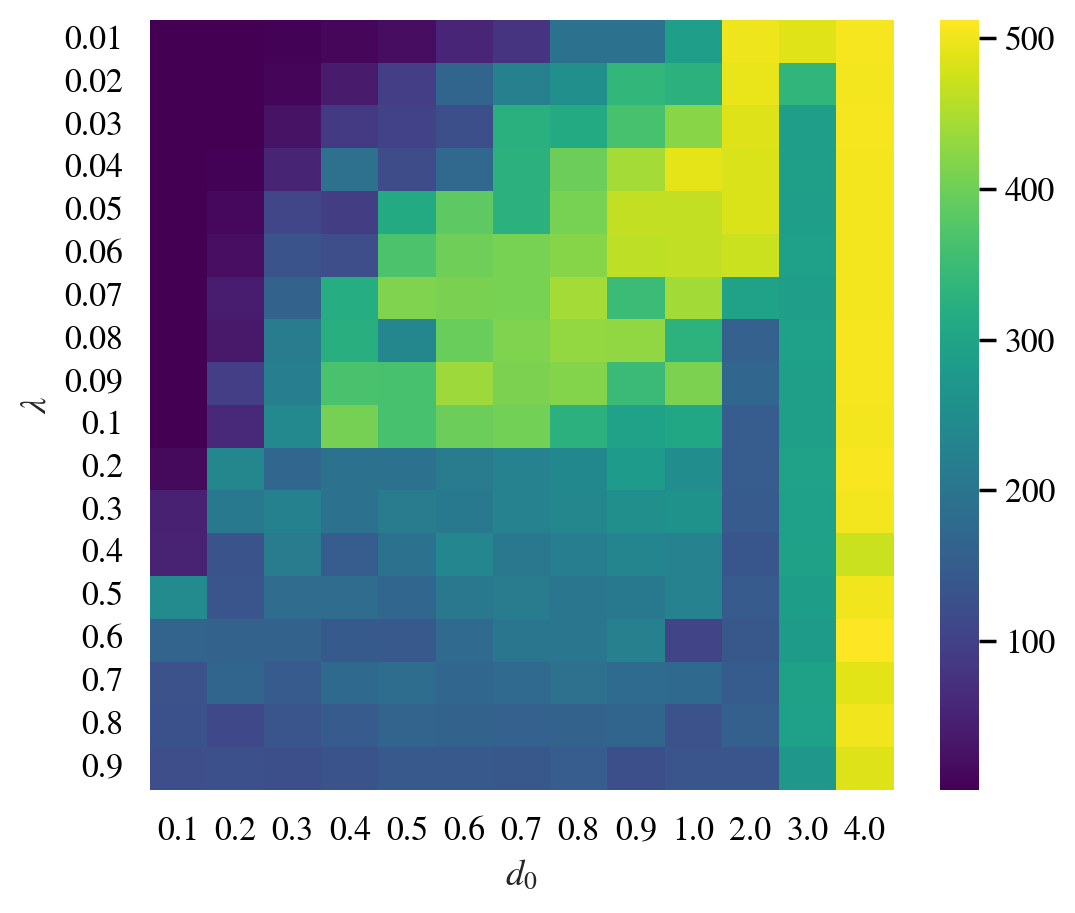

In [37]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    model = SpatialGroups(
        strengthLambda=l, distanceD0=d0, boundaryLength=5, 
        tqdm=False, savePath="./data", randomSeed=10, overWrite=False
    ) 
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    deltaX = _delta_x(lastPositionX, lastPositionX[:, np.newaxis])
    distances = np.sqrt(np.sum(deltaX ** 2, axis=-1))

    maps.loc[l, d0] = (distances <= d0).sum(axis=1).mean()

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

## 时序序参量

### 旋转中心空间分布

In [4]:
models = [
    # SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    # SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    # SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcp(models, savePath="./figs/egs/4.3.png")

  0%|          | 0/1 [00:00<?, ?it/s]

### 旋转半径分布

In [3]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcr(models, savePath="./figs/egs/totalRadius.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心空间聚集程度1

In [11]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcaop(models, opType=1, savePath="./figs/egs/centerAggOp1_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心空间聚集程度2

In [10]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcaop(models, opType=2, savePath="./figs/egs/centerAggOp2_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心平均距离分布

In [16]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvca(models, opType=1, savePath="./figs/egs/centerAgg1_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 中心距离倒数加权相位同步程度（各粒子）

In [10]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_drpa(models, savePath="./figs/egs/weightedPhaseSync_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 中心距离倒数加权相位同步程度（算数平均）

In [11]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_drpaop(models, savePath="./figs/egs/weightedPhaseSyncOp_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内相位同步程度 (各粒子)

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_ldpa(models, savePath="./figs/egs/limitDisPhaseSync_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内相位同步程度 (算数平均)

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_ldpaop(models, savePath="./figs/egs/limitDisPhaseSyncOp_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 聚类数

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_ccop(models, savePath="./figs/egs/classCountsOp.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内中心数（各粒子）

In [5]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_cnc(models, savePath="./figs/egs/centerNearbyCounts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内中心数（算数平均）

In [6]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_cncop(models, savePath="./figs/egs/centerNearbyCountsOp.png")

  0%|          | 0/4 [00:00<?, ?it/s]

## 相位单位圆

In [3]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

./data/CorrectCoupling_uniform_0.900_2.00_10.h5


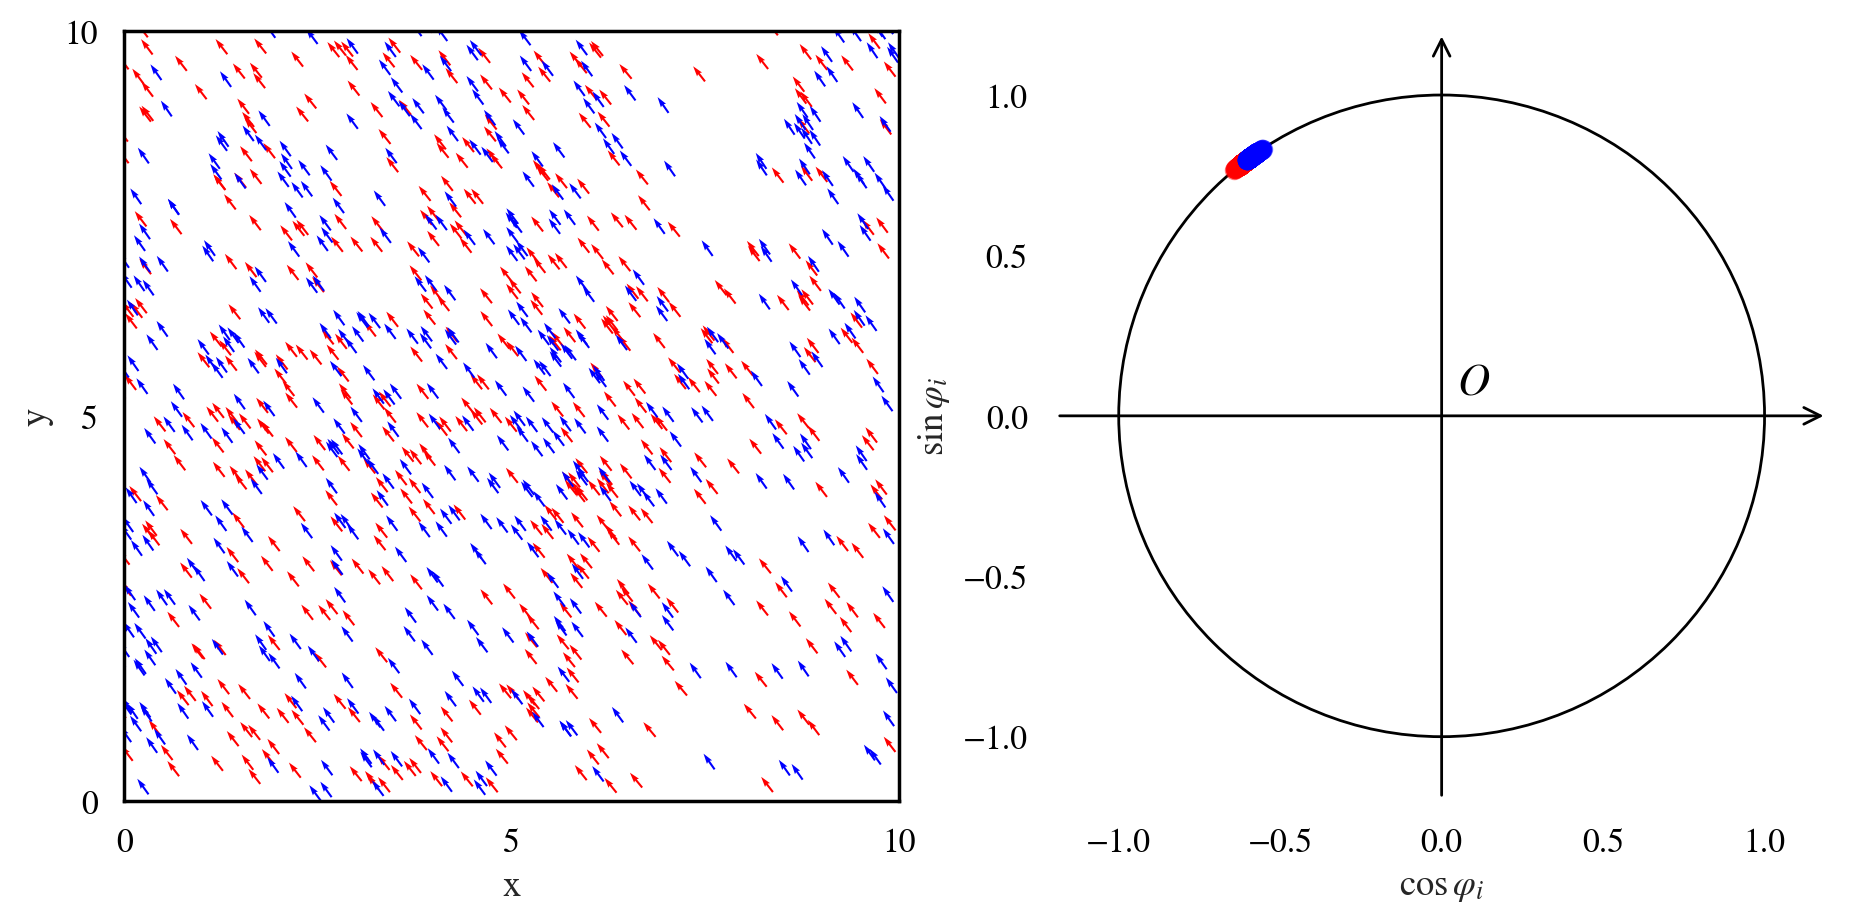

In [25]:
import matplotlib.patches as patches
model = SpatialGroups(strengthLambda=0.01, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    idx = -76
    positionX = totalPositionX[idx]
    phaseTheta = totalPhaseTheta[idx]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='red'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='blue'
    )
    ax1.spines['bottom'].set_color('black')
    ax1.spines['top'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.set_xticks([0, 5, 10])
    ax1.set_yticks([0, 5, 10])
    ax1.set_xlabel(r"x")
    ax1.set_ylabel(r"y")
    ax1.grid(False)
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax2.add_artist(circle)
    ax2.scatter(
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='red', alpha=0.5
    )
    ax2.scatter(
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='blue', alpha=0.5
    )
    lim = 1.2
    ax2.add_patch(patches.FancyArrowPatch(
        (0, -lim), (0, lim),
        color='black', arrowstyle='->', mutation_scale=15
    ))
    ax2.add_patch(patches.FancyArrowPatch(
        (-lim, 0), (lim, 0),
        color='black', arrowstyle='->', mutation_scale=15
    ))
    ax2.text(0.1, 0.1, r"$O$", ha="center", va="center", fontsize=16)
    
    ax2.set_xlim(-lim, lim)
    ax2.set_ylim(-lim, lim)
    ax2.grid(False)
    ax2.set_yticks([-1., -0.5, 0., 0.5, 1.])
    ax2.set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax2.set_xlabel(r"$\cos\varphi_i$")
    ax2.set_ylabel(r"$\sin\varphi_i$")

    plt.savefig(f"./figs/unitCircle/{model}_2d_circle.png", dpi=200)
    plt.show()

models = [
    # SpatialGroups(strengthLambda=0.3, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
    SpatialGroups(strengthLambda=0.9, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.5, distanceD0=0.1, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.009, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.01, distanceD0=0.1, savePath="./data", uniform=True, randomSeed=10),
]

for model in models:
    plot_last(model)

In [15]:
targetPath = f"./data/{model}.h5"
# print(targetPath)
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPositionX.shape

(1402, 1000, 2)

In [ ]:
shift = 0

def plot_last(key: str):

    l, d0 = key.split("_")
    l, d0 = float(l), float(d0)
    model = SpatialGroups(strengthLambda=l, distanceD0=d0, dt=0.01, tqdm=False)

    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    lastPositionX = positionX[key]
    lastPhaseTheta = phaseTheta[key]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        lastPositionX[class1, 0], lastPositionX[class1, 1],
        np.cos(lastPhaseTheta[class1]), np.sin(lastPhaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        lastPositionX[class2, 0], lastPositionX[class2, 1],
        np.cos(lastPhaseTheta[class2]), np.sin(lastPhaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2, projection='3d')
    hist, bins = np.histogram(lastPhaseTheta[class1], bins=100, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax2.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist), hist]), 
        color='tomato', alpha=0.5, edgecolor="tomato"
    )
    hist, bins = np.histogram(lastPhaseTheta[class2], bins=100, range=(-np.pi, np.pi))
    ax2.plot_surface(
        np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
        np.array([np.zeros_like(hist), hist]), 
        color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
    )
    ax2.set_xlabel(r"$\cos(\theta_I)$")
    ax2.set_ylabel(r"$\sin(\theta_I)$")

    plt.savefig(f"./figs/unitCircle/{model}.eps", dpi=250)
    plt.close()

for key in tqdm(positionX.keys()):
    plot_last(key)

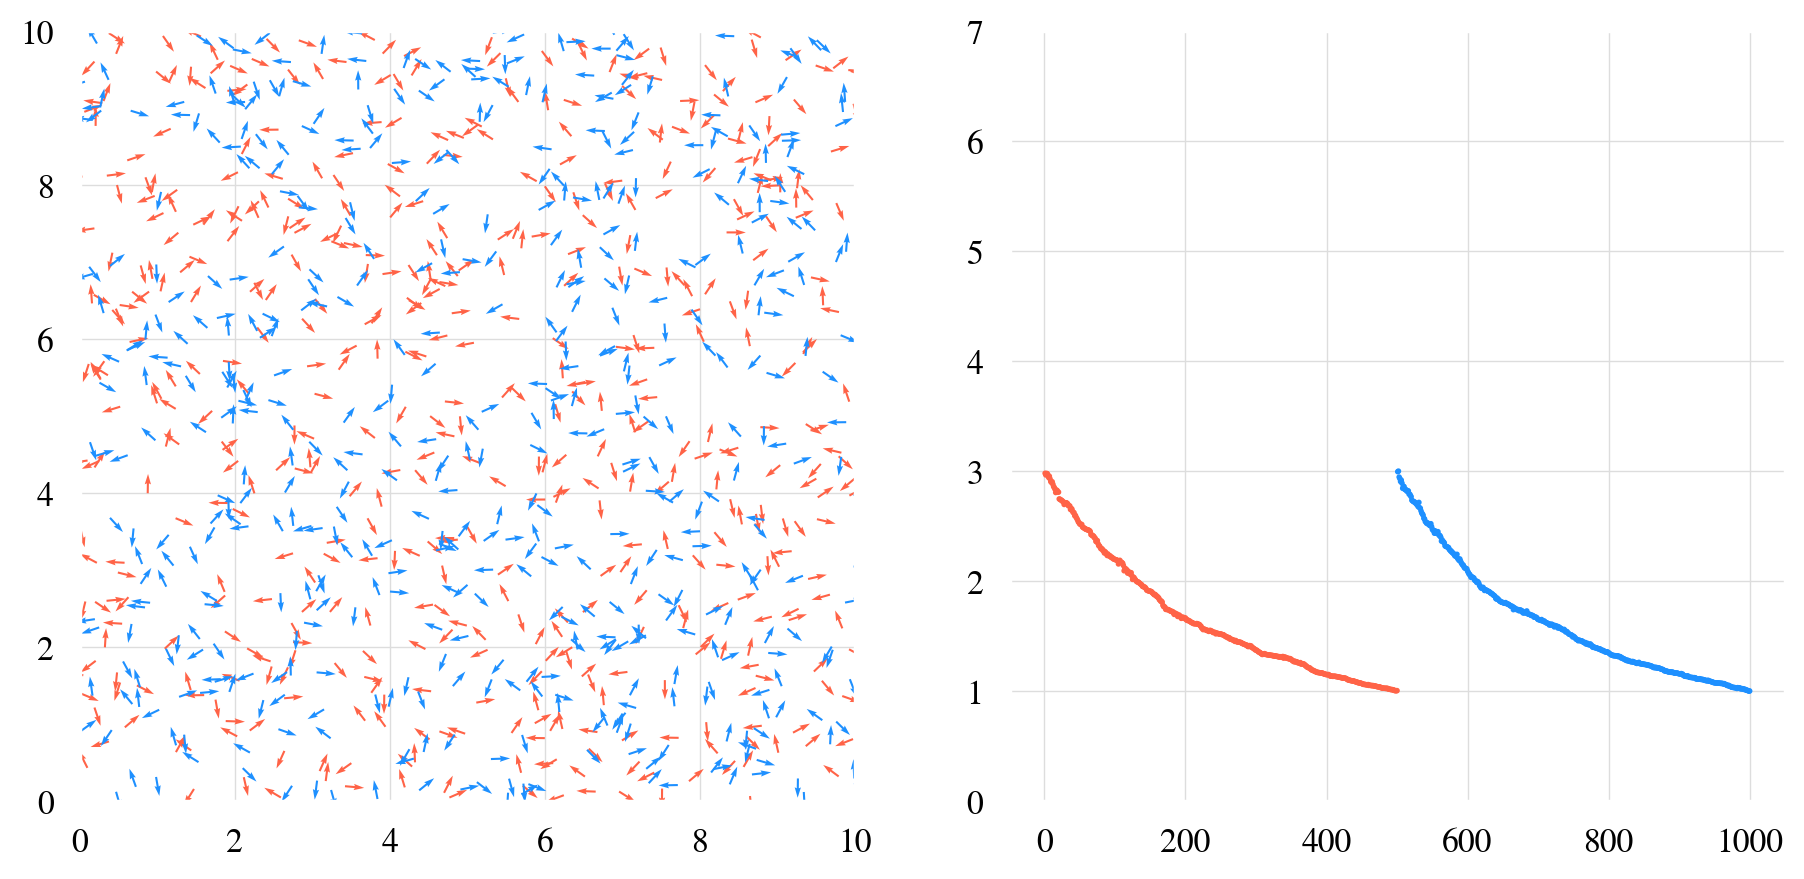

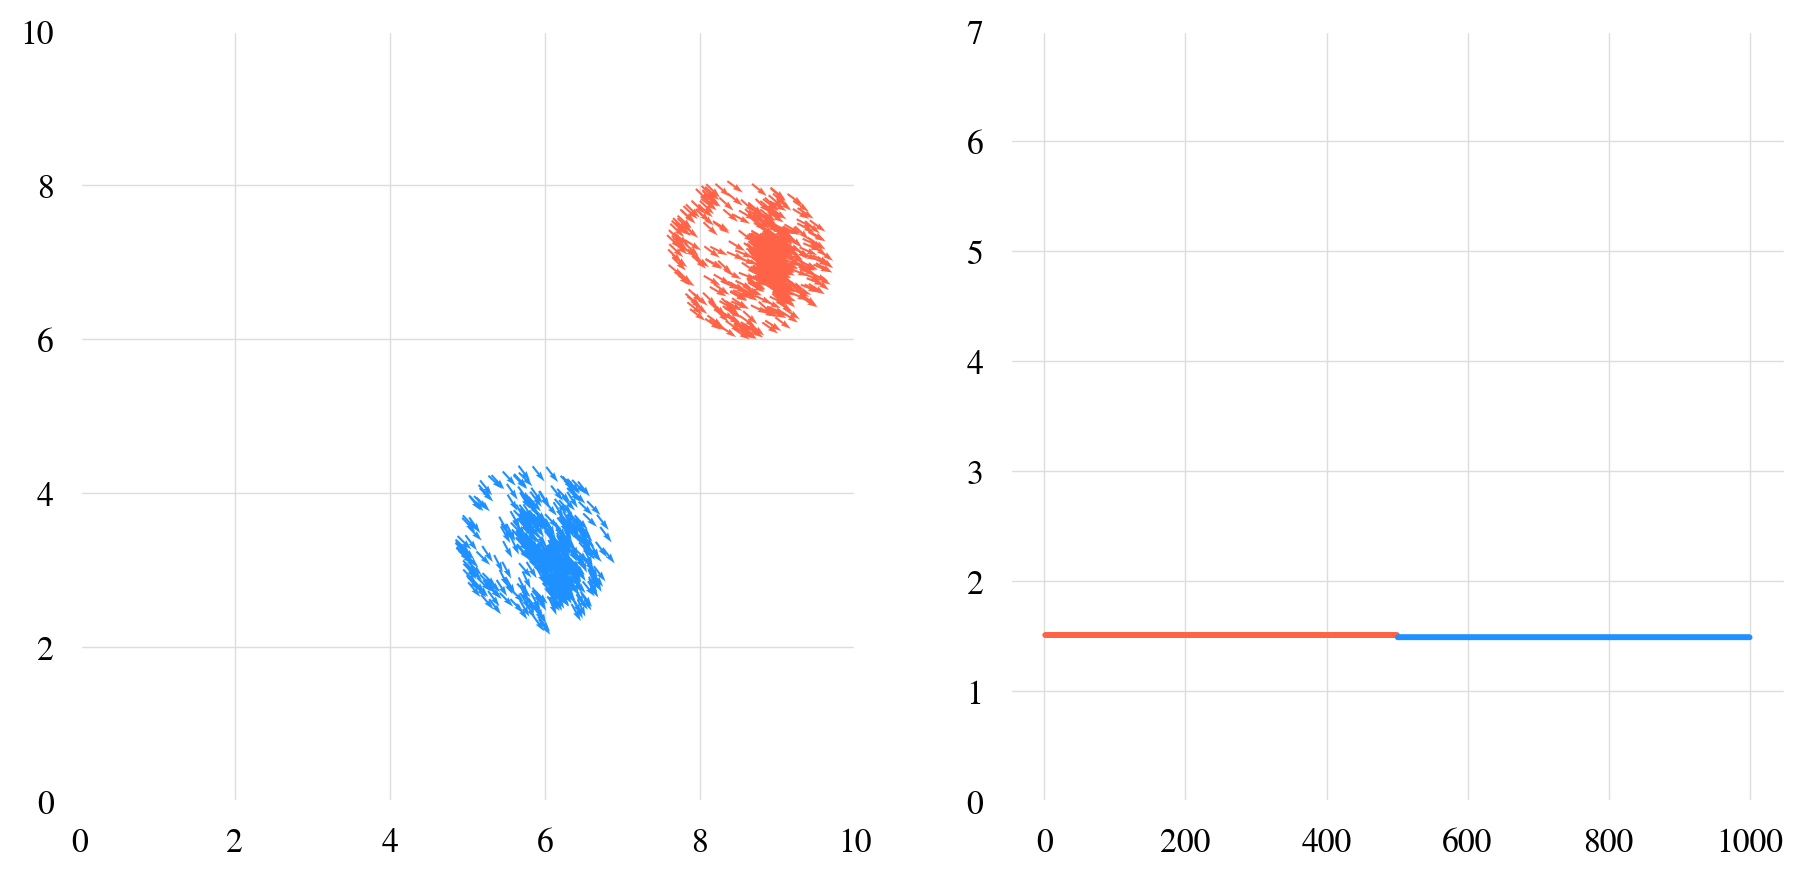

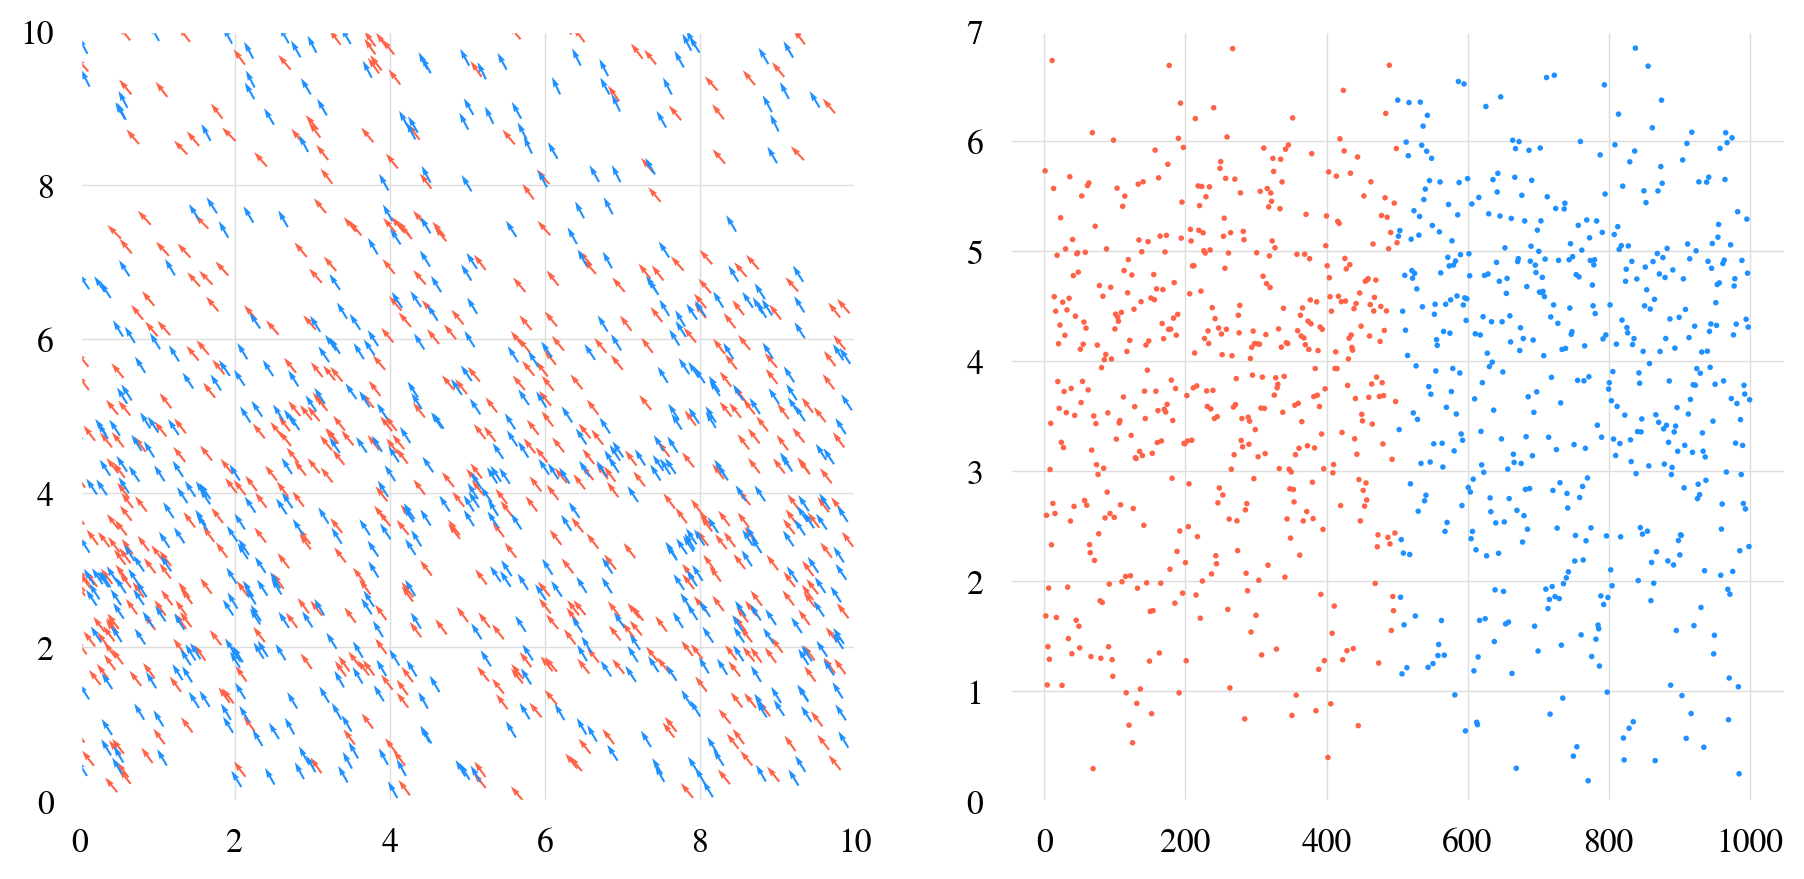

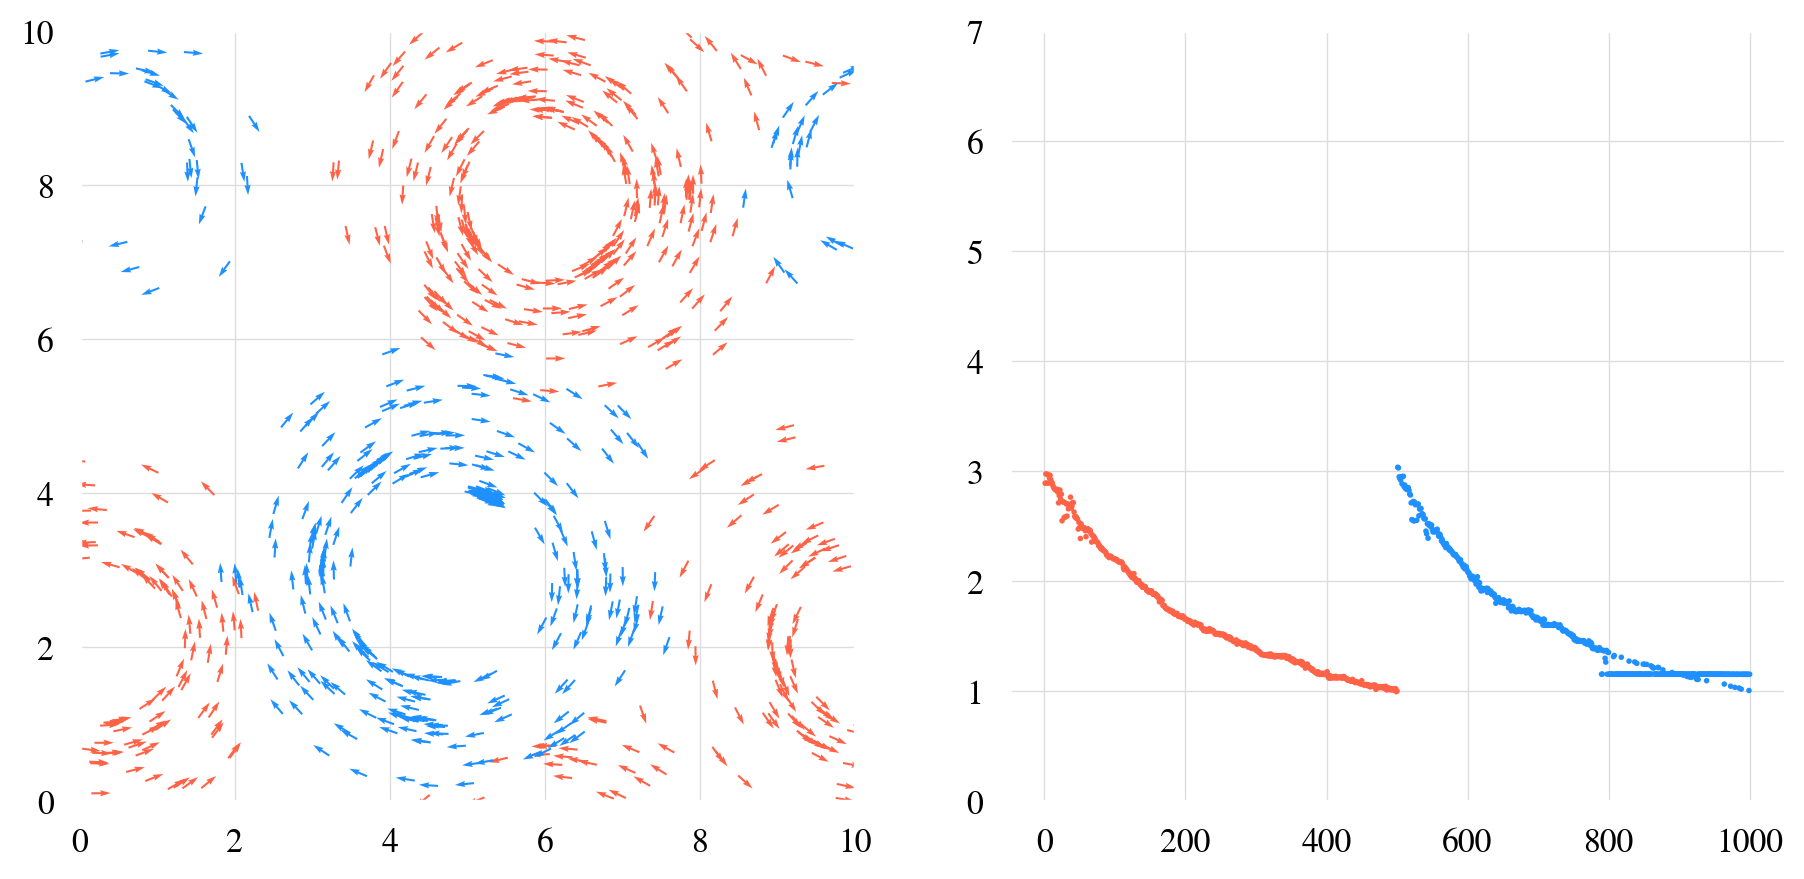

In [15]:
@nb.njit
def _delta_x(positionX, others):
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
    positionX, phaseTheta, _ = sa.get_state()
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    fig, ax = plt.subplots(figsize=(11, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    centers = sa.centers
    deltaX = _delta_x(positionX, centers)
    radius = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    omega1 = np.abs(model.omegaTheta[class1])
    omega2 = np.abs(model.omegaTheta[class2])
    omegaIdx = np.concatenate([np.argsort(omega1), np.argsort(omega2) + 500])
    
    ax2 = plt.subplot(1, 2, 2)
    color = ["tomato"] * 500 + ["dodgerblue"] * 500
    ax2.scatter(
        x=np.arange(1, 1001), y=radius[omegaIdx], color=color, s=1
    )
    # ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(0, 7)

    plt.savefig(f"./figs/{model}_radius.png", dpi=200)
    plt.show()

models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]

for model in models:
    plot_last(model)

In [9]:
def count_intervals(sequence, num_bins):
    min_val = 2 * np.pi
    max_val = 0

    # 使用numpy的histogram函数计算每个区间的计数
    hist, bins = np.histogram(sequence, bins=num_bins, range=(min_val, max_val))

    # 创建每个区间的标签
    labels = []
    for i in range(num_bins):
        labels.append('[{:.2f}, {:.2f})'.format(bins[i], bins[i+1]))

    return dict(zip(labels, hist))

In [20]:
model = SpatialGroups(
    strengthLambda=0.01, distanceD0=2,  
    tqdm=False, savePath="./data", uniform=True, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)


In [42]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
for model in models:
    sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
    deltaOmega1 = (
        (
            sa.totalPointTheta[-2000:, :].mean(axis=0) / model.dt
            - np.mean(model.omegaTheta)
        ) ** 2
    ).mean()

    # plt.plot(deltaOmega1, label=rf"$\lambda={model.strengthLambda}$, $d_0={model.distanceD0}$")

# plt.legend()
# plt.show()

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.9, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]

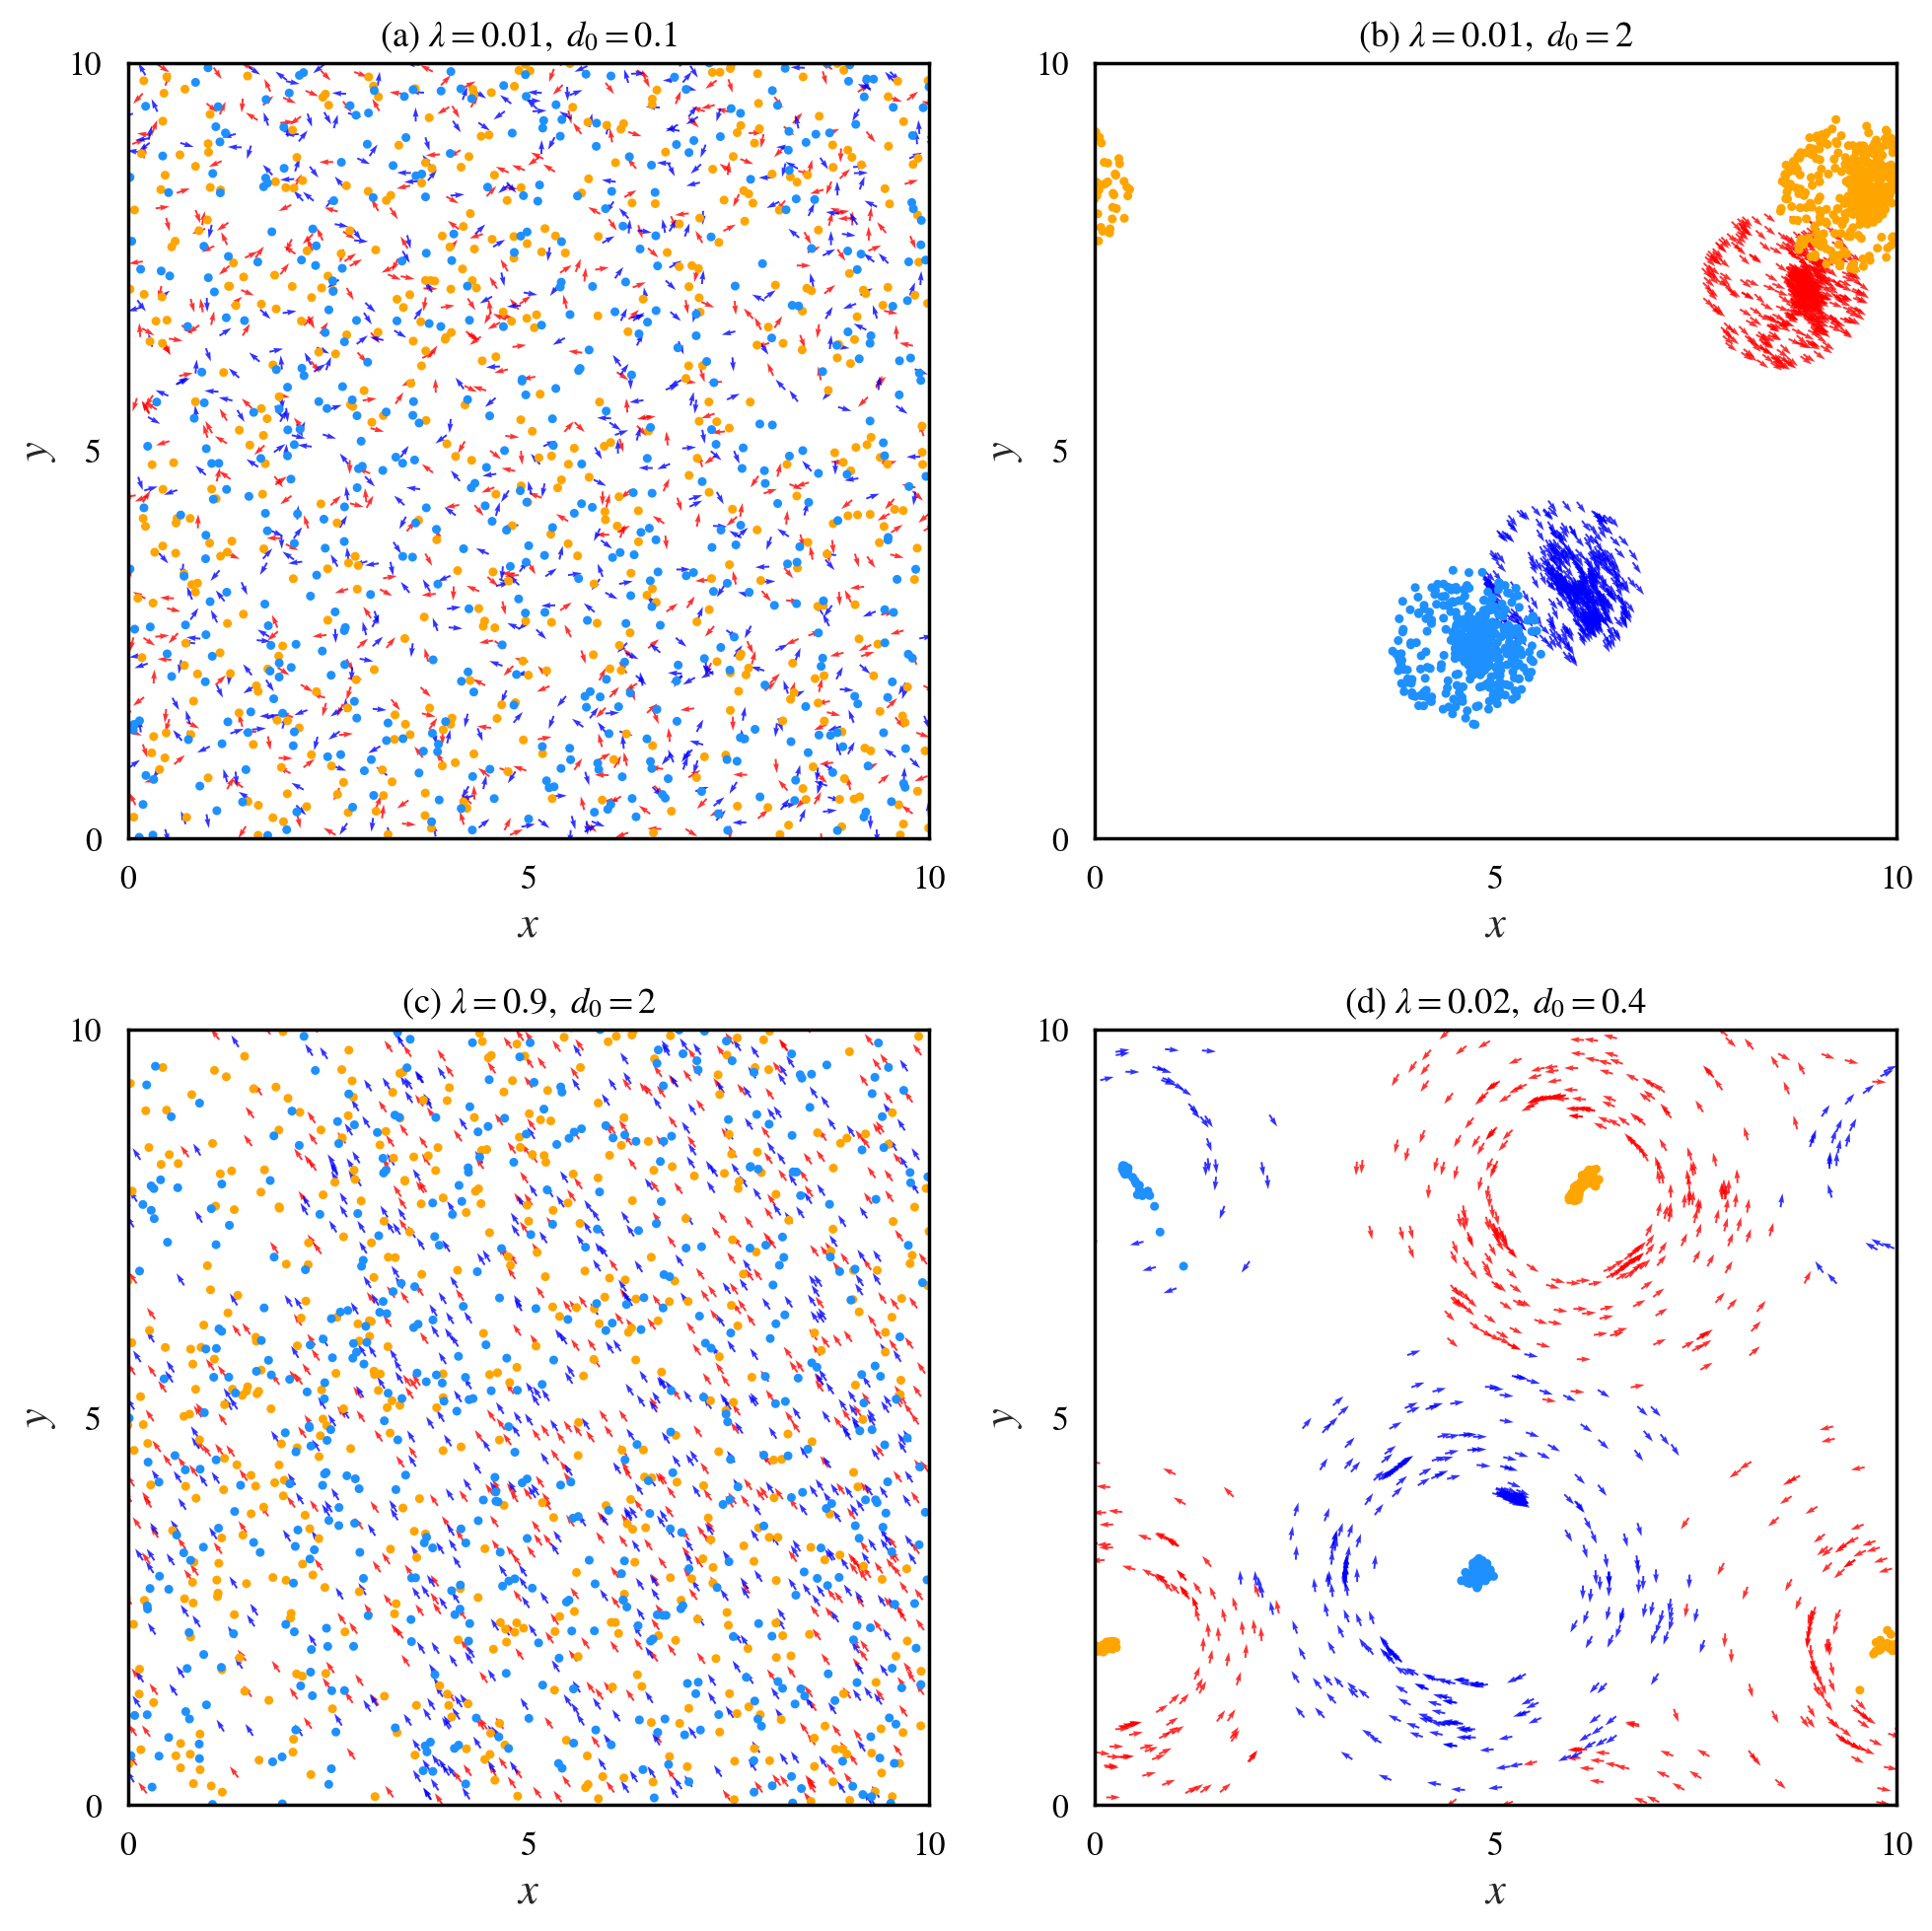

In [5]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(2, 2, 1)
model = models[0]
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
sa.plot_centers(ax=ax1, index=-1)
ax1.set_title(rf"(a) $\lambda={model.strengthLambda},\ d_0={model.distanceD0}$")

ax2 = plt.subplot(2, 2, 2)
model = models[1]
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
sa.plot_centers(ax=ax2, index=-1)
ax2.set_title(rf"(b) $\lambda={model.strengthLambda},\ d_0={model.distanceD0}$")

ax3 = plt.subplot(2, 2, 3)
model = models[2]
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
sa.plot_centers(ax=ax3, index=-1)
ax3.set_title(rf"(c) $\lambda={model.strengthLambda},\ d_0={model.distanceD0}$")

ax4 = plt.subplot(2, 2, 4)
model = models[3]
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
sa.plot_centers(ax=ax4, index=-1)
ax4.set_title(rf"(d) $\lambda={model.strengthLambda},\ d_0={model.distanceD0}$")

plt.tight_layout()
plt.show()

In [77]:
model = SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)

(0.0, 10.0)

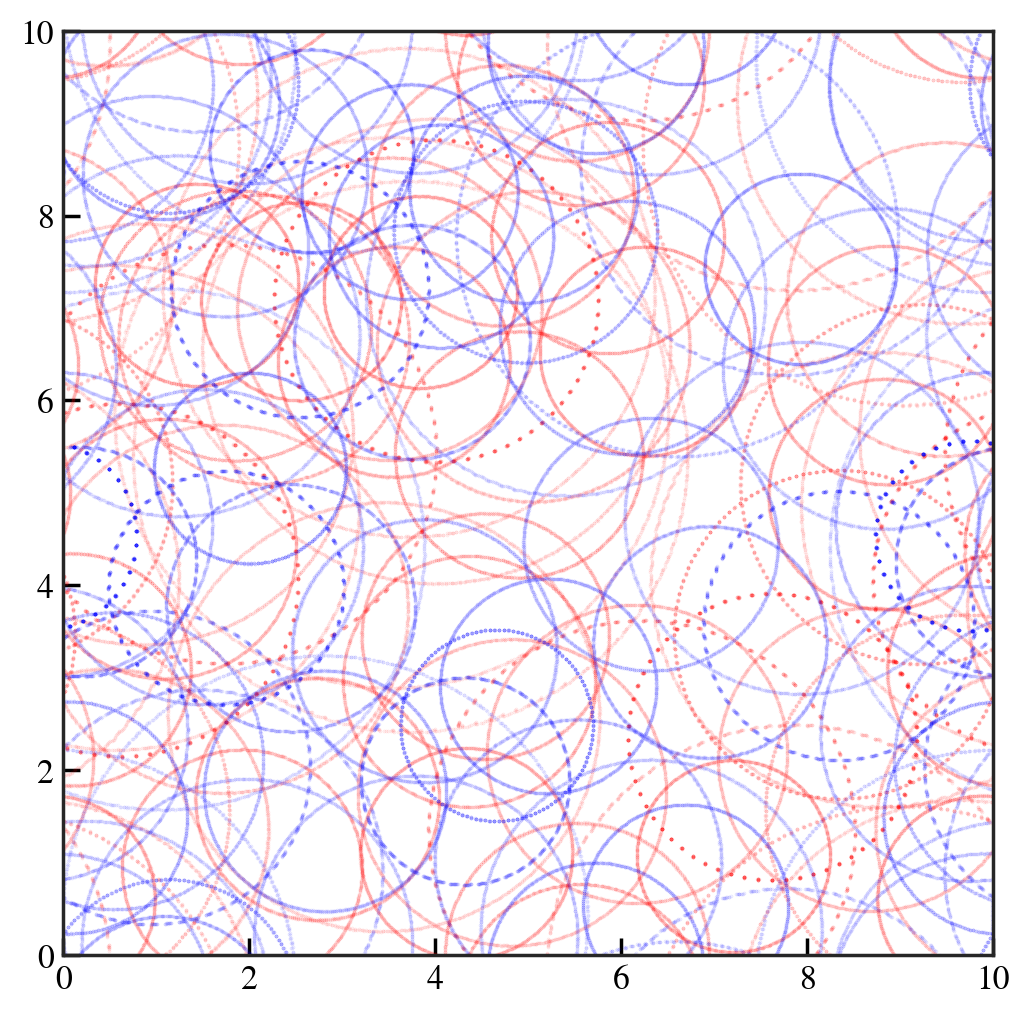

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(
    sa.totalPositionX[-1000:, :50, 0], sa.totalPositionX[-1000:, :50, 1], 
    s=0.1, alpha=0.1, color="red"
)
plt.scatter(
    sa.totalPositionX[-1000:, -50:, 0], sa.totalPositionX[-1000:, -50:, 1], 
    s=0.1, alpha=0.1, color="blue"
)
plt.tick_params(direction='in')
plt.xlim(0, 10)
plt.ylim(0, 10)

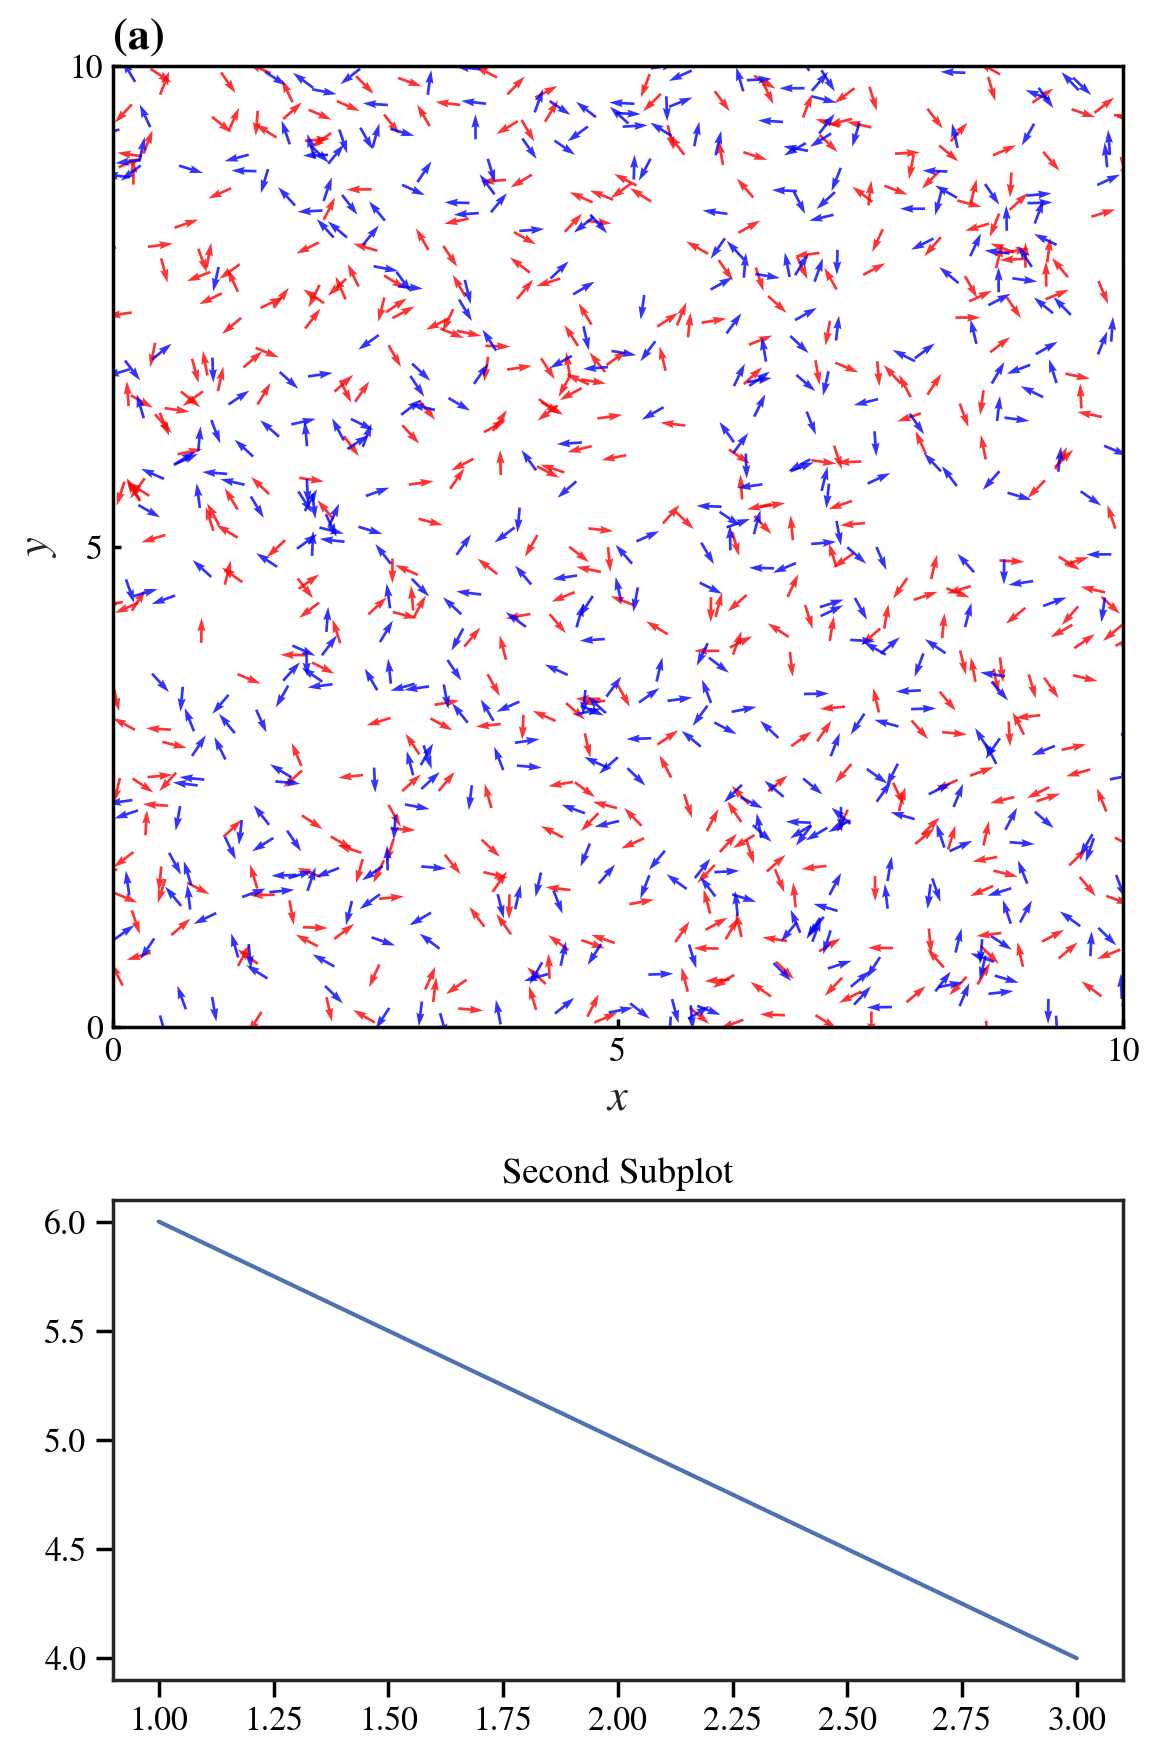

In [72]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# 创建画布和子图网格
fig = plt.figure(figsize=(6, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# 绘制第一张子图
ax1 = plt.subplot(gs[0])
plor_last_state(f"{0.01:.3f}_{0.1:.2f}", ax=ax1, showTicks=True)
ax1.set_title('(a)', loc="left", fontweight='bold', fontsize=16)

# 绘制第二张子图
ax2 = plt.subplot(gs[1])
ax2.plot([1, 2, 3], [6, 5, 4])
ax2.set_title('Second Subplot')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.3)

# 显示图形
plt.tight_layout()
plt.show()

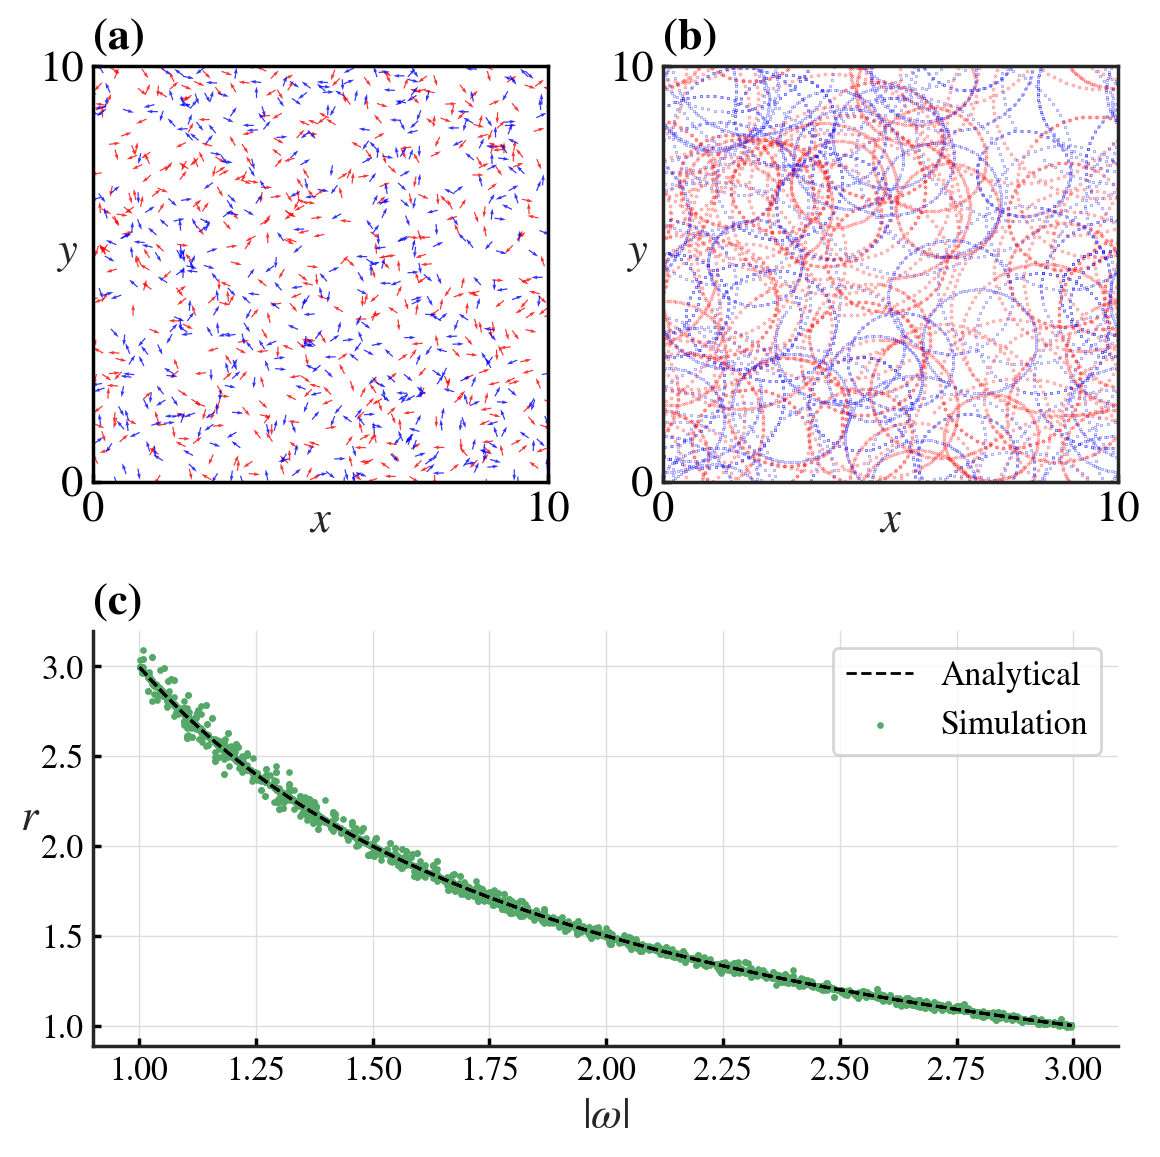

In [190]:
import matplotlib.pyplot as plt

# 创建图形窗口和子图网格
fig = plt.figure(figsize=(6, 6))

# 定义子图网格的行列和跨度
rows = 4
cols = 2
rowspan = [2, 2]  # 每个子图所占的行数，第四行占据两行


# 创建子图
ax1 = plt.subplot2grid((rows, cols), (0, 0), rowspan=rowspan[0])
ax2 = plt.subplot2grid((rows, cols), (0, 1), rowspan=rowspan[1])
ax3 = plt.subplot2grid((rows, cols), (2, 0), colspan=2, rowspan=2)

ax1.tick_params(direction='in', length=3)

plor_last_state(f"{0.01:.3f}_{0.1:.2f}", ax=ax1, showTicks=True)

ax2.scatter(
    sa.totalPositionX[-100:, :50, 0], sa.totalPositionX[-100:, :50, 1], 
    s=0.1, alpha=0.4, color="red"
)
ax2.scatter(
    sa.totalPositionX[-100:, -50:, 0], sa.totalPositionX[-100:, -50:, 1], 
    s=0.01, alpha=1, color="blue"
)
tickSize = 16
ax2.tick_params(direction='in', length=3)
ax2.set_xticks([0, 10], fontsize=tickSize)
ax2.set_yticks([0, 10], fontsize=tickSize)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.set_xlabel(r"$x$", fontsize=tickSize)
ax2.set_ylabel(r"$y$", fontsize=tickSize, rotation=0)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=tickSize)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=tickSize)
ax2.xaxis.labelpad = -10
ax2.yaxis.labelpad = -10

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.06, 0.01)
])
distanceDs = [0.1]
legend = True

for rangeLambda in rangeLambdas:
    
    model = SpatialGroups(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax3.scatter(omegaTheta, distances, s=2, color="C2")
    ax3.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1)
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        ax3.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Analytical")
        ax3.scatter(omegaTheta, distances, label="Simulation", s=2, color="C2")
        plt.legend(frameon=True, facecolor="white")

# ax3取消右边和上边的边框
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.grid(True)
# ax3.set_yticks([1, 2, 3])
ax3.set_ylabel(r"$r$", fontsize=tickSize, rotation=0)
ax3.set_xlabel(r"$\left| \omega \right|$", fontsize=tickSize)

# 设置子图标题
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=16)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=16)
ax3.set_title("(c)", loc="left", fontweight='bold', fontsize=16)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/disorderState.pdf", bbox_inches="tight")